<center>
    <h1><b>Data-Mining Techniques Assignment</b></h1>
</center>

This notebook is part of a university course assignment **'Data-Mining Techniques'**. This project involves e-commerce analysis using the **Amazon Product Dataset**. The project is devided into two parts:
1. Data Exploration & feature engineering, and
2. machine learning tasks including clustering, classification, recommendation system, and sentiment analysis.

The members of this assignment are shown in the following table

<div align="center">

| Ονοματεπώνυμο    | Αριθμός Μητρώου  |        email         |
| :-------------:  | :-------------:  |   :-------------:    |
| Ζήκας Αντώνιος   | 1115202100038    | sdi2100038@di.uoa.gr |
| Κώτσιλας Σταύρος | 1115201700292    | sdi1700292@di.uoa.gr |

</div>

# Notebook Settings

## Number of records to work
Here we define a constant that describes how many records for each category will be downloaded

**Set it to `-1` to download all the available records**

In [1]:
RECORDS_COUNT = 1000 # -1 to download all records

## Plotting theme
Firstly we will initialize the plotting theme of the graphs. This is an optional and can be be skipped

In [2]:
import matplotlib.pyplot as plt

theme = 'light' # You can adjust the theme here, options are 'dark' or 'light'
if theme == 'dark':
    plt.style.use('dark_background')
else:
    plt.style.use('default')

# Part 1: Data Pre-processing
In the first part we will explore the datasets we are going to use and do some pre-processing and analysis on them. We chose to work with the following categories:
1. `Digital_Music`
2. `Gift_Cards`
3. `Magazine_Subscriptions`
4. `Handmade_Products`
5. `All_Beauty`

## Task 1: Data Exploration and Feature Engineering
### 1. Data Preperation
In this section we will extract our datafor the five categories above. We will download the JSON files and we will parse them in order to create the CSV files that we are going to use for the rest of the tasks.

#### Downloading the datasets
We are going to define a function that will download the datasets for us. Here we are going to use `streamming=True` so we don't download the entire dataset at once, but we will be able to access its contents. This is done for experimenting purposes.

In [3]:
import warnings
from datasets import load_dataset

warnings.filterwarnings("ignore")

def download_datasets(categories, data_type="review"):
    ''' Downloads the specified type of datasets (review or meta) for the given categories. '''
    
    if data_type not in ["review", "meta"]:
        raise ValueError("Invalid data_type. Choose either 'review' or 'meta'.")
    
    # Loop through the categories and download the datasets
    # using the load_dataset function from the datasets library
    datasets = []
    for category in categories:
        print(f"Downloading {data_type} dataset for category: {category}")
        dataset = load_dataset(
            "McAuley-Lab/Amazon-Reviews-2023",
            f"raw_{data_type}_{category}",
            trust_remote_code=True,
            streaming=True
        )
        datasets.append(dataset)
    
    return datasets

/opt/anaconda3/envs/Data-Mining-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's download the datasets for the five categories specified above. We will download both **reviews** and **meta** data for the categories.

In [4]:
# Define the categories to download (can be modified as needed)
categories = [
    "Digital_Music", 
    "Gift_Cards", 
    "Magazine_Subscriptions", 
    "Handmade_Products", 
    "All_Beauty"
]

# Download the review and meta data for the specified categories
review_datasets = download_datasets(categories, data_type="review")
meta_datasets = download_datasets(categories, data_type="meta")

print("\nDatasets downloaded successfully.")


Datasets downloaded successfully.


#### Creation of CSV files
Finally let's create the corresponding **CSV files** for the datasets and save them locally to use them later. We will also define a function that will handle this for us.

In [5]:
import pandas as pd
import os

def construct_csv_files(categories, datasets, max_records=100, output_dir="output"):
    ''' Constructs dictionaries for each category from the review or meta datasets and saves them as CSV files. '''
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    
    categories_dictionaries = {}
    for category, dataset in zip(categories, datasets):
        csv_path = os.path.join(output_dir, f"{category}_data.csv")
        
        # Check if the CSV file already exists
        if os.path.exists(csv_path):
            print(f" - CSV file for category '{category}' already exists at: {csv_path}. Skipping creation.")
            continue
        
        for i, record in enumerate(dataset['full']):
            if i == 0:
                dictionary = {key: [] for key in record.keys()}
            for key in record.keys():
                dictionary[key].append(record[key])
            if i == max_records - 1:
                break
        
        # Save the dictionary as a CSV file
        df = pd.DataFrame(dictionary)
        df.to_csv(csv_path, index=False)
        print(f" - CSV file created for category '{category}' at: {csv_path} ({len(df)} records)")
        
        categories_dictionaries[category] = dictionary
    
    return categories_dictionaries

In [6]:
data_path = "../data/raw" # Path to save the CSV files

print("\nConstructing CSV files for review datasets...")
review_dictionaries = construct_csv_files(categories, review_datasets, max_records=RECORDS_COUNT, output_dir=f"{data_path}/review")

print("\nConstructing CSV files for meta datasets...")
meta_dictionaries = construct_csv_files(categories, meta_datasets, max_records=RECORDS_COUNT, output_dir=f"{data_path}/meta")


Constructing CSV files for review datasets...
 - CSV file for category 'Digital_Music' already exists at: ../data/raw/review/Digital_Music_data.csv. Skipping creation.
 - CSV file for category 'Gift_Cards' already exists at: ../data/raw/review/Gift_Cards_data.csv. Skipping creation.
 - CSV file for category 'Magazine_Subscriptions' already exists at: ../data/raw/review/Magazine_Subscriptions_data.csv. Skipping creation.
 - CSV file for category 'Handmade_Products' already exists at: ../data/raw/review/Handmade_Products_data.csv. Skipping creation.
 - CSV file for category 'All_Beauty' already exists at: ../data/raw/review/All_Beauty_data.csv. Skipping creation.

Constructing CSV files for meta datasets...
 - CSV file for category 'Digital_Music' already exists at: ../data/raw/meta/Digital_Music_data.csv. Skipping creation.
 - CSV file for category 'Gift_Cards' already exists at: ../data/raw/meta/Gift_Cards_data.csv. Skipping creation.
 - CSV file for category 'Magazine_Subscriptions' 

#### Loading the CSV files to Pandas Dataframes
Next we will pre-process and clean our data. We start by loading the loading the CSV files we just saved to **Pandas Dataframes**. This will let us work more conviniently. Let's create a function for that and load the dataframes.

In [7]:
def load_csv_files(categories, data_path="../data"):
    ''' Loads the CSV files for the specified categories into pandas dataframes. '''
    
    # Initialize a dictionary to hold the dataframes
    dataframes = {'review': {}, 'meta': {}}
    
    # Loop through the categories and load the CSV files into dataframes
    for mode in ['review', 'meta']:
        for category in categories:
            csv_path = os.path.join(data_path, mode, f"{category}_data.csv")
            if os.path.exists(csv_path):
                dataframes[mode][category] = pd.read_csv(csv_path)
                print(f" - Loaded {mode} data for category '{category}' from: {csv_path}")
            else:
                print(f" - CSV file for category '{category}' not found at: {csv_path}. Skipping loading.")
    
    return dataframes

In [8]:
dataframes = load_csv_files(categories, data_path=data_path)

 - Loaded review data for category 'Digital_Music' from: ../data/raw/review/Digital_Music_data.csv
 - Loaded review data for category 'Gift_Cards' from: ../data/raw/review/Gift_Cards_data.csv
 - Loaded review data for category 'Magazine_Subscriptions' from: ../data/raw/review/Magazine_Subscriptions_data.csv
 - Loaded review data for category 'Handmade_Products' from: ../data/raw/review/Handmade_Products_data.csv
 - Loaded review data for category 'All_Beauty' from: ../data/raw/review/All_Beauty_data.csv
 - Loaded meta data for category 'Digital_Music' from: ../data/raw/meta/Digital_Music_data.csv
 - Loaded meta data for category 'Gift_Cards' from: ../data/raw/meta/Gift_Cards_data.csv
 - Loaded meta data for category 'Magazine_Subscriptions' from: ../data/raw/meta/Magazine_Subscriptions_data.csv
 - Loaded meta data for category 'Handmade_Products' from: ../data/raw/meta/Handmade_Products_data.csv
 - Loaded meta data for category 'All_Beauty' from: ../data/raw/meta/All_Beauty_data.csv


#### Dataframes size
Let's create a pie plot to represent the size of each category dataframe.

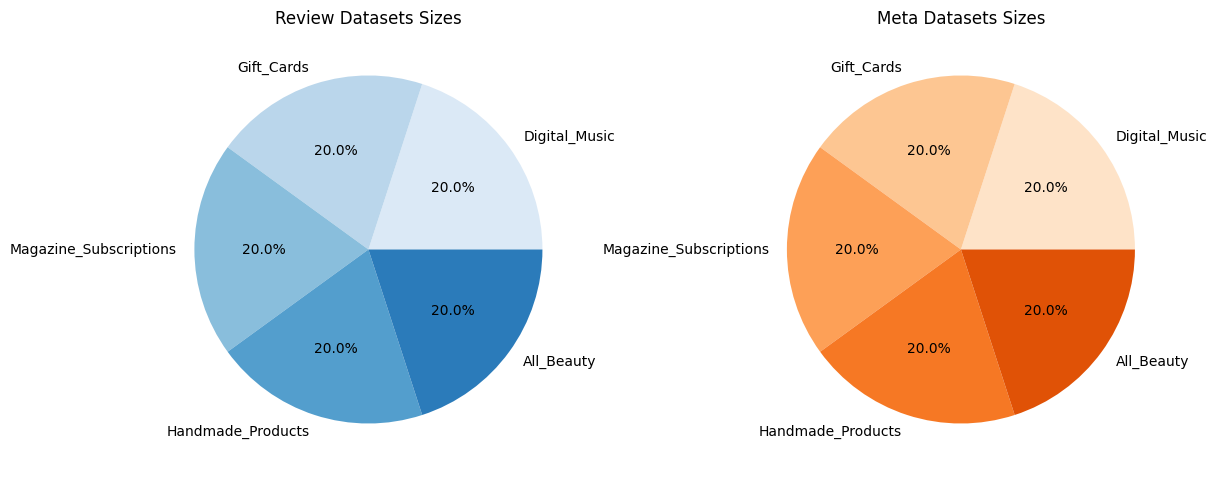

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

review_sizes = [dataframes['review'][category].shape[0] for category in categories]
meta_sizes = [dataframes['meta'][category].shape[0] for category in categories]
review_color = sns.color_palette('Blues')
meta_color = sns.color_palette('Oranges')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pie(review_sizes, labels=categories, autopct="%1.1f%%", colors=review_color)
axes[1].pie(meta_sizes, labels=categories, autopct="%1.1f%%", colors=meta_color)

axes[0].set_title('Review Datasets Sizes')
axes[1].set_title('Meta Datasets Sizes')

plt.tight_layout()
plt.show()

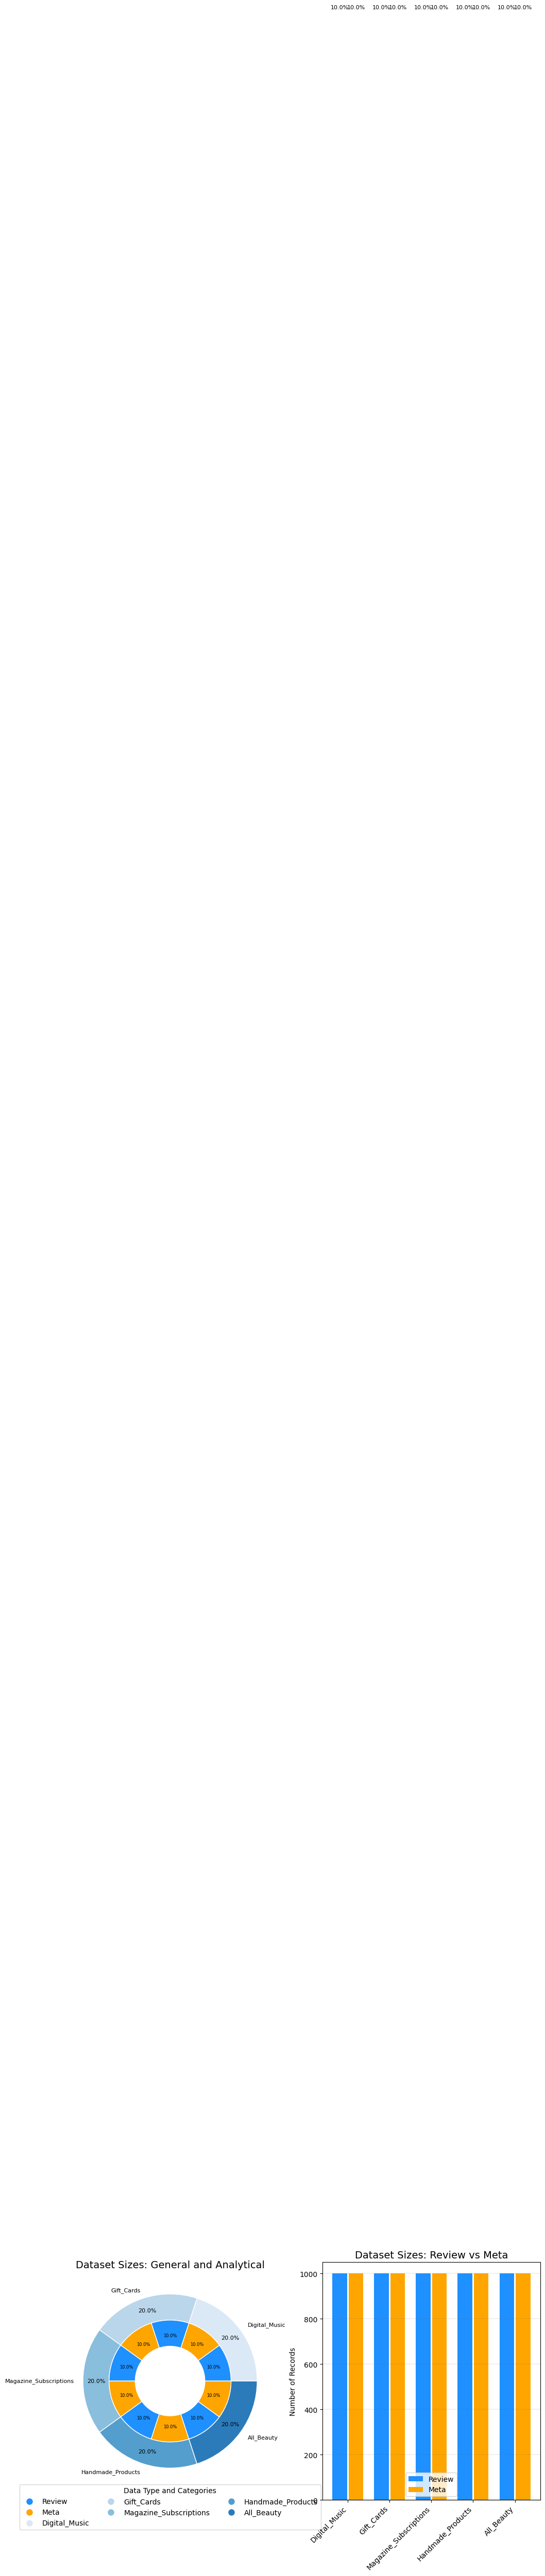

In [10]:
# Custom function to format percentages
def autopct_format(pct):
    return f"{pct:.1f}%" if pct >= 0.3 else ""

# General pie plot information about the datasets sizes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Calculate the total size for each category (review + meta)
total_sizes = [review_sizes[i] + meta_sizes[i] for i in range(len(categories))]

# Create the outer ring (general size of each category)
outer_colors = sns.color_palette('Blues')
axes[0].pie(
    total_sizes, 
    labels=categories, 
    autopct=autopct_format, 
    colors=outer_colors, 
    radius=1, 
    wedgeprops=dict(width=0.3, edgecolor='w'),
    pctdistance=0.85,  # Position percentages closer to the outer ring
    textprops={'fontsize': 8, 'color': 'black'}  # Set font size and color for percentages
)

# Create the inner ring (analytical size: review size and meta size)
inner_sizes = sum([[review_sizes[i], meta_sizes[i]] for i in range(len(categories))], [])
inner_colors = ['dodgerblue', 'orange'] * len(categories)  # Specific colors for 'Review' and 'Meta'
axes[0].pie(
    inner_sizes, 
    labels=None,  # Remove labels from the inner pie chart
    autopct=autopct_format, 
    colors=inner_colors, 
    radius=0.7, 
    wedgeprops=dict(width=0.3, edgecolor='w'),
    pctdistance=0.75,  # Position percentages closer to the inner ring
    textprops={'fontsize': 6, 'color': 'black'}  # Set font size and color for percentages
)

# Add a legend for 'Review', 'Meta', and categories
axes[0].legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='dodgerblue', markersize=10, label='Review'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Meta'),
        *[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=outer_colors[i], markersize=10, label=categories[i]) for i in range(len(categories))]
    ],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),  # Move the legend to the bottom
    ncol=3,  # Arrange legend items in 3 columns
    title="Data Type and Categories"
)

axes[0].set_title("Dataset Sizes: General and Analytical", fontsize=14)

# Create a bar plot next to the pie plot
bar_width = 0.35
gap = 0.02  # Small gap between bars of the same category
x = range(len(categories))
axes[1].bar([i - gap for i in x], review_sizes, width=bar_width, label='Review', color='dodgerblue')
axes[1].bar([i + bar_width + gap for i in x], meta_sizes, width=bar_width, label='Meta', color='orange')

# Add labels and title to the bar plot
axes[1].set_xticks([i + bar_width / 2 for i in x])
axes[1].set_xticklabels(categories, rotation=45, ha='right')
axes[1].set_ylabel("Number of Records")
axes[1].set_title("Dataset Sizes: Review vs Meta", fontsize=14)
axes[1].legend()
axes[1].grid(axis='y', color='dimgray', linestyle='dashed', linewidth=0.2)

# Add percentages above the bars
total_records = sum(total_sizes)
for i, (review_size, meta_size) in enumerate(zip(review_sizes, meta_sizes)):
    review_pct = (review_size / total_records) * 100
    meta_pct = (meta_size / total_records) * 100
    axes[1].text(i - gap, review_size + 10**4, f"{review_pct:.1f}%", ha='center', fontsize=8)  # Increased offset
    axes[1].text(i + bar_width + gap, meta_size + 10**4, f"{meta_pct:.1f}%", ha='center', fontsize=8)  # Increased offset

plt.tight_layout()
plt.show()

#### Dataframes Visualization
Let's have a look at the **review** and **meta** data for the first category.

In [11]:
review_df = dataframes['review'][categories[0]]
meta_df = dataframes['meta'][categories[0]]

In [12]:
review_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Nice,If i had a dollar for how many times I have pl...,[],B004RQ2IRG,B004RQ2IRG,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,1618972613292,0,True
1,5.0,Excellent,awesome sound - cant wait to see them in perso...,[],B0026UZEI0,B0026UZEI0,AHGAOIZVODNHYMNCBV4DECZH42UQ,1308167525000,0,True
2,5.0,Great service,This is a great cd. Good music and plays well....,[],B0055JSYHC,B0055JSYHC,AFGEM6BXCYHUILEOA3P2ZYBEF2TA,1615838793006,0,True
3,1.0,No good,"These are not real German singers, they have a...",[],B000F9SMUQ,B000F9SMUQ,AH3OG6QD6EDJGZRVCFKV4B66VWNQ,1405219741000,0,True
4,3.0,"Cool concept, so-so execution...",I first heard this playing in a Nagoya shop an...,[],B0049D1WVK,B0049D1WVK,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,1309029595000,0,False


In [13]:
meta_df.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Digital Music,Baja Marimba Band,4.9,8,[],[],NaN,"{'hi_res': [None, None], 'large': ['https://m....","{'title': [], 'url': [], 'user_id': []}",NaN,[],"{""Date First Available"": ""February 28, 2010""}",B000V87RP2,NaN,NaN,NaN
1,Digital Music,'80s Halloween-All Original Artists & Recordings,5.0,3,[],[],14.98,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}","Love and Rockets (Artist), Duran Duran (...",[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc...",B0062F0MJQ,NaN,NaN,NaN
2,Digital Music,TRIO +1,5.0,1,[],['CD ALBUM'],57.99,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Rob Wasserman Format: Audio CD,[],"{""Is Discontinued By Manufacturer"": ""No"", ""Pac...",B00005GT12,NaN,NaN,NaN
3,Digital Music,"Gold and Silver: Lehar, Delibes, Lanner, Johan...",5.0,1,[],[],29.91,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}","Franz Lehar (Composer), Leo Delibes (Com...",[],"{""Manufacturer"": ""Hungaroton / White Label"", ""...",B0007PD2BW,NaN,NaN,NaN
4,Digital Music,Grateful Dead Dave's Picks Volume 25 Live at B...,4.9,20,[],['Sold out. Numbered limited edition'],149.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}","Grateful Dead (Artist, Orchestra) Format: ...",[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc...",B079CPD45R,NaN,NaN,NaN


#### Data Cleaning
Now that we have our data loaded into pandas dataframe, we can start **pre-processing** them. The **Data Cleaning** that we are going to apply consists of three tasks:
1. Handle missing values,
2. Normalize prices, and
3. Pre-process text

##### i) Handle Missing Values
We start the cleaning procedure by **handling missing values**. We will start by identifying which columns of the datasets have missing values.

In [14]:
# First search in the review dataframes
for category in categories:
    dataframe = dataframes['review'][category]
    missing_summary = dataframe.isnull().sum()
    print(f"Missing summary in {category} review data:\n{missing_summary[missing_summary > 0]}")

Missing summary in Digital_Music review data:
Series([], dtype: int64)
Missing summary in Gift_Cards review data:
Series([], dtype: int64)
Missing summary in Magazine_Subscriptions review data:
Series([], dtype: int64)
Missing summary in Handmade_Products review data:
Series([], dtype: int64)
Missing summary in All_Beauty review data:
Series([], dtype: int64)


In [15]:
# Next, search in the meta dataframes
for category in categories:
    dataframe = dataframes['meta'][category]
    missing_summary = dataframe.isnull().sum()
    print(f"Missing summary in {category} meta data:\n{missing_summary[missing_summary > 0]}")

Missing summary in Digital_Music meta data:
price               390
store                61
bought_together    1000
subtitle           1000
author             1000
dtype: int64
Missing summary in Gift_Cards meta data:
main_category       117
price               641
store                15
bought_together    1000
subtitle           1000
author             1000
dtype: int64
Missing summary in Magazine_Subscriptions meta data:
price              1000
store                53
bought_together    1000
subtitle           1000
author             1000
dtype: int64
Missing summary in Handmade_Products meta data:
price               327
store                10
bought_together    1000
subtitle           1000
author             1000
dtype: int64
Missing summary in All_Beauty meta data:
price               799
store                99
bought_together    1000
subtitle           1000
author             1000
dtype: int64


As we see the missing values we are dealing with are refering to the **meta** data of the datasets. The review datasets seems to not have any missing value. As for the meta datasets, it seems to have empty values at columns: **main_category, price, store, bought_together, subtitle, and author**. We are going to deal with these missing values as follows:
- `main_category` $\rightarrow$ fill with the most common value from the other rows
- `price` $\rightarrow$ fill with 0.0
- `store` $\rightarrow$ fill with ''
- `bought_together` $\rightarrow$ fill with empty list []
- `subtitle` $\rightarrow$ fill with ''
- `author` $\rightarrow$ fill with ''

Let's define a function that will handle missing values for a dataframe, using the above sceptic

In [16]:
def handle_missing_values(dataframe):
    ''' Handles missing values in a given dataframe. '''
    
    # Fill 'main_category' with the most common value of the column
    dataframe['main_category'] = dataframe['main_category'].fillna(dataframe['main_category'].mode()[0])

    # Fill 'price' with the 0.0 value
    dataframe['price'] = dataframe['price'].fillna(0.0)

    # Fill 'store' with empty string
    dataframe['store'] = dataframe['store'].fillna("")

    # Fill 'bought_together' with empty list
    dataframe['bought_together'] = dataframe['bought_together'].fillna("[]")

    # Fill 'title' with empty string
    dataframe['title'] = dataframe['title'].fillna("")

    # Fill 'subtitle' with empty strings
    dataframe['subtitle'] = dataframe['subtitle'].fillna("")

    # Fill 'author' with empty string
    dataframe['author'] = dataframe['author'].fillna("")

    return dataframe

Let's apply the above function to all meta dataframes

In [17]:
# Handle missing values for all the meta dataframes
for category in categories:
    dataframes['meta'][category] = handle_missing_values(dataframes['meta'][category])

And finally let's see the results

In [18]:
# Next, search in the meta dataframes
for category in categories:
    dataframe = dataframes['meta'][category]
    missing_summary = dataframe.isnull().sum()
    print(f"Missing summary in {category} meta data:\n{missing_summary[missing_summary > 0]}")

Missing summary in Digital_Music meta data:
Series([], dtype: int64)
Missing summary in Gift_Cards meta data:
Series([], dtype: int64)
Missing summary in Magazine_Subscriptions meta data:
Series([], dtype: int64)
Missing summary in Handmade_Products meta data:
Series([], dtype: int64)
Missing summary in All_Beauty meta data:
Series([], dtype: int64)


As we see all the missing values have been removed with the previous logic, and we can continue with normalizing prices.

##### ii) Normalizing prices
Next we will normalize the prices of the meta dataframes. There are many ways of normalizing numeric values. Some of them are:
- Min-Max normalization (Scaling to 0 - 1)
- Standardization (Z-score Normalization)
- Log Normalization
- Currency Normalization (less common)

In this notebook we will use **Min-Max normalization (Scaling to 0 - 1)**. Let's define a function for that.

In [19]:
def normalize_prices(dataframe):
    ''' 
    Normalizes the prices in a given dataframe, using min-max normalization (scaling to [0, 1]),
    and creating a new column 'normalized_price' to store the normalized values'.
    '''
    # Ensure the 'price' column is numeric
    dataframe['price'] = dataframe['price'].replace('—', 0.0)
    dataframe['price'] = pd.to_numeric(dataframe['price'])
    min_price, max_price = dataframe['price'].min(), dataframe['price'].max()
    if min_price == max_price:
        dataframe['normalized_price'] = 0.0
    else:
        dataframe['normalized_price'] = (dataframe['price'] - min_price) / (max_price - min_price)
        
    return dataframe

Let's apply this function to the meta data.

In [20]:
for category in categories:
    dataframe = dataframes['meta'][category]
    dataframe = normalize_prices(dataframe)
    dataframes['meta'][category] = dataframe
    print(f" - Normalized prices for category '{category}'")

 - Normalized prices for category 'Digital_Music'
 - Normalized prices for category 'Gift_Cards'
 - Normalized prices for category 'Magazine_Subscriptions'
 - Normalized prices for category 'Handmade_Products'
 - Normalized prices for category 'All_Beauty'


Let's have a look at the meta data of the first category and check what is the **maximum** and **minimum** price in each dataset related to their normalized values.

In [21]:
dataframes['meta'][categories[0]].head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,normalized_price
0,Digital Music,Baja Marimba Band,4.9,8,[],[],0.00,"{'hi_res': [None, None], 'large': ['https://m....","{'title': [], 'url': [], 'user_id': []}",,[],"{""Date First Available"": ""February 28, 2010""}",B000V87RP2,[],,,0.000000
1,Digital Music,'80s Halloween-All Original Artists & Recordings,5.0,3,[],[],14.98,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}","Love and Rockets (Artist), Duran Duran (...",[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc...",B0062F0MJQ,[],,,0.016442
2,Digital Music,TRIO +1,5.0,1,[],['CD ALBUM'],57.99,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Rob Wasserman Format: Audio CD,[],"{""Is Discontinued By Manufacturer"": ""No"", ""Pac...",B00005GT12,[],,,0.063650
3,Digital Music,"Gold and Silver: Lehar, Delibes, Lanner, Johan...",5.0,1,[],[],29.91,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}","Franz Lehar (Composer), Leo Delibes (Com...",[],"{""Manufacturer"": ""Hungaroton / White Label"", ""...",B0007PD2BW,[],,,0.032829
4,Digital Music,Grateful Dead Dave's Picks Volume 25 Live at B...,4.9,20,[],['Sold out. Numbered limited edition'],149.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}","Grateful Dead (Artist, Orchestra) Format: ...",[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc...",B079CPD45R,[],,,0.164629


In [22]:
for category in categories:
    print(f"{category}: Max price: {dataframes['meta'][category]['price'].max()}", end=", ")
    print(f"Min price: {dataframes['meta'][category]['price'].min()}", end=", ")
    print(f"Normalized max price: {dataframes['meta'][category]['normalized_price'].max()}", end=", ")
    print(f"Normalized min price: {dataframes['meta'][category]['normalized_price'].min()}")

Digital_Music: Max price: 911.08, Min price: 0.0, Normalized max price: 1.0, Normalized min price: 0.0
Gift_Cards: Max price: 2000.0, Min price: 0.0, Normalized max price: 1.0, Normalized min price: 0.0
Magazine_Subscriptions: Max price: 0.0, Min price: 0.0, Normalized max price: 0.0, Normalized min price: 0.0
Handmade_Products: Max price: 800.0, Min price: 0.0, Normalized max price: 1.0, Normalized min price: 0.0
All_Beauty: Max price: 179.95, Min price: 0.0, Normalized max price: 1.0, Normalized min price: 0.0


As we see the prices have been normalized successfully. We can continue with the text preprocessing.

##### iii) Pre-processing text
We will now begin the text pre-processing of the data. Fistly we will decide witch columns need to be processed. As we saw in the dataframes representations there are two columns in the review data that contain text. These are **`title`** and **`text`**, while in the meta data only the **`title`** column contain text. So we are going to apply text pre-processing as follows:
- For the review data $\rightarrow$ columns `title` and `text`
- For the meta data $\rightarrow$ column `title`

The next step is to determine what **pre-processing techniques** will be used. We have decided to apply the following rules on the pre-processing:
1. **Lowercase** text,
2. Remove **punctuation**,
3. **Stemming** and **Lemmatization** of words,
4. Remove **URLS** (https://...), **user mentions** (@user123) and **hashtags** (#hashtag_example), and
5. Remove **stop-words**

We will create a function that will apply the above rules to a single string variable. First we will make sure all the appropriate packages are installed in our system.

In [23]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/antonis/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/antonis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

And then we will define our function

In [24]:
import re

def preprocess_text(text):
    ''' 
    Preprocesses the text by removing special characters, converting to lowercase, 
    and removing stop-words. 
    '''
    if not isinstance(text, str):
        return ''
    
    # 1. Lowercase the text and remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    # 2. Remove stop-words
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(tokens)

    # 3. Apply stemming or lemmatization to words
    stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(tokens)

    # 4. Remove URLs, user mentions, digits, extra spaces and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return ' '.join(tokens)

Let's apply the cleaning function to the columns mentioned above

In [25]:
import time

output_file_path = "../data/processed/"
if os.path.exists(output_file_path):
    print(f"Data are already processed and stored in {output_file_path}.")
    dataframes = load_csv_files(categories, data_path=output_file_path)
else:
    print("Pre-processing started")
    os.makedirs(output_file_path)
    t0 = time.time()

    print(" - Preprocessing review data...")
    os.makedirs(f"{output_file_path}/review", exist_ok=True)
    for category, dataframe in dataframes['review'].items():
        print(f"  * Preprocessing {category} review data...")
        dataframe['cleaned_title'] = dataframe['title'].apply(preprocess_text)
        dataframe['cleaned_text'] = dataframe['text'].apply(preprocess_text)
        dataframe.to_csv(f"{output_file_path}/review/{category}_data.csv", index=False)

    print(" - Preprocessing meta data...")
    os.makedirs(f"{output_file_path}/meta", exist_ok=True)
    for category, dataframe in dataframes['meta'].items():
        print(f"  *  Preprocessing {category} meta data...")
        dataframe['cleaned_title'] = dataframe['title'].apply(preprocess_text)
        dataframe.to_csv(f"{output_file_path}/meta/{category}_data.csv", index=False)

    print(f"\nPreprocessing completed in {time.time() - t0:.2f} seconds")

Data are already processed and stored in ../data/processed/.
 - Loaded review data for category 'Digital_Music' from: ../data/processed/review/Digital_Music_data.csv
 - Loaded review data for category 'Gift_Cards' from: ../data/processed/review/Gift_Cards_data.csv
 - Loaded review data for category 'Magazine_Subscriptions' from: ../data/processed/review/Magazine_Subscriptions_data.csv
 - Loaded review data for category 'Handmade_Products' from: ../data/processed/review/Handmade_Products_data.csv
 - Loaded review data for category 'All_Beauty' from: ../data/processed/review/All_Beauty_data.csv
 - Loaded meta data for category 'Digital_Music' from: ../data/processed/meta/Digital_Music_data.csv
 - Loaded meta data for category 'Gift_Cards' from: ../data/processed/meta/Gift_Cards_data.csv
 - Loaded meta data for category 'Magazine_Subscriptions' from: ../data/processed/meta/Magazine_Subscriptions_data.csv
 - Loaded meta data for category 'Handmade_Products' from: ../data/processed/meta/Han

Let's take a look at the pre-processed data.

In [26]:
dataframes['review'][categories[0]].head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,cleaned_title,cleaned_text
0,5.0,Nice,If i had a dollar for how many times I have pl...,[],B004RQ2IRG,B004RQ2IRG,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,1618972613292,0,True,nice,dollar mani time play cd mani time ask alexa p...
1,5.0,Excellent,awesome sound - cant wait to see them in perso...,[],B0026UZEI0,B0026UZEI0,AHGAOIZVODNHYMNCBV4DECZH42UQ,1308167525000,0,True,excel,awesom sound cant wait see person alway miss town
2,5.0,Great service,This is a great cd. Good music and plays well....,[],B0055JSYHC,B0055JSYHC,AFGEM6BXCYHUILEOA3P2ZYBEF2TA,1615838793006,0,True,great servic,great cd good music play well seller respond b...
3,1.0,No good,"These are not real German singers, they have a...",[],B000F9SMUQ,B000F9SMUQ,AH3OG6QD6EDJGZRVCFKV4B66VWNQ,1405219741000,0,True,good,real german singer accent noth advertis music ...
4,3.0,"Cool concept, so-so execution...",I first heard this playing in a Nagoya shop an...,[],B0049D1WVK,B0049D1WVK,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,1309029595000,0,False,cool concept soso execut,first heard play nagoya shop fell love remix k...


In [27]:
dataframes['meta'][categories[0]].head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,normalized_price,cleaned_title
0,Digital Music,Baja Marimba Band,4.9,8,[],[],0.00,"{'hi_res': [None, None], 'large': ['https://m....","{'title': [], 'url': [], 'user_id': []}",NaN,[],"{""Date First Available"": ""February 28, 2010""}",B000V87RP2,[],NaN,NaN,0.000000,baja marimba band
1,Digital Music,'80s Halloween-All Original Artists & Recordings,5.0,3,[],[],14.98,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}","Love and Rockets (Artist), Duran Duran (...",[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc...",B0062F0MJQ,[],NaN,NaN,0.016442,80 halloweenal origin artist record
2,Digital Music,TRIO +1,5.0,1,[],['CD ALBUM'],57.99,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Rob Wasserman Format: Audio CD,[],"{""Is Discontinued By Manufacturer"": ""No"", ""Pac...",B00005GT12,[],NaN,NaN,0.063650,trio 1
3,Digital Music,"Gold and Silver: Lehar, Delibes, Lanner, Johan...",5.0,1,[],[],29.91,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}","Franz Lehar (Composer), Leo Delibes (Com...",[],"{""Manufacturer"": ""Hungaroton / White Label"", ""...",B0007PD2BW,[],NaN,NaN,0.032829,gold silver lehar delib lanner johann strauss ii
4,Digital Music,Grateful Dead Dave's Picks Volume 25 Live at B...,4.9,20,[],['Sold out. Numbered limited edition'],149.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}","Grateful Dead (Artist, Orchestra) Format: ...",[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc...",B079CPD45R,[],NaN,NaN,0.164629,grate dead dave pick volum 25 live broom count...


### 2. Ratings and Reviews
In this section we will perform some **Exploratory Data Analysis** (EDA) by creating and showing several plots that describe the behaviour of the data according to different tasks. 

#### 2.1 Product Ratings
The first task is to find the distribution between product ratings within each of the 5 categories we have selected. For this task we use `seaborn`, a very popular library for plotting, and creates **5 plots**, one for each category showing the distribution between user ratings for defferent products of a specific category.  

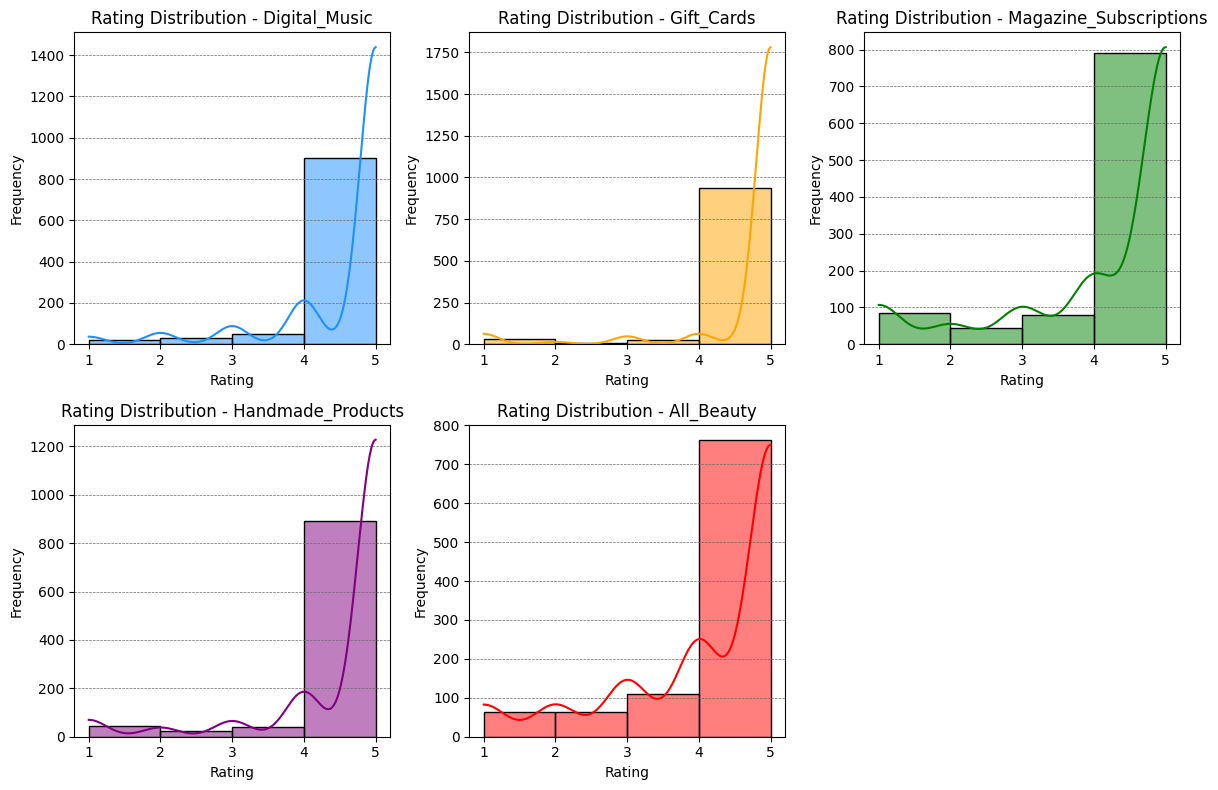

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram for the rating distribution of each category
colors = ['dodgerblue', 'orange', 'green', 'purple', 'red']
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Plot the rating distribution for each category
for i, category in enumerate(categories):
    sns.histplot(dataframes['review'][category]['rating'], bins=4, kde=True, ax=axes[i], color=colors[i], stat='frequency')
    axes[i].set_title(f"Rating Distribution - {category}")
    axes[i].set_xlabel("Rating")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(axis='y', color='dimgray', linestyle='dashed', linewidth=0.5)

# Hide any unused subplot axes
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


As we can see from the above graphs, the **most frequent rating** for each category is **5** and the second one is **1** which makes sence. Finally let's create a bar plot showing the average rating for every category.

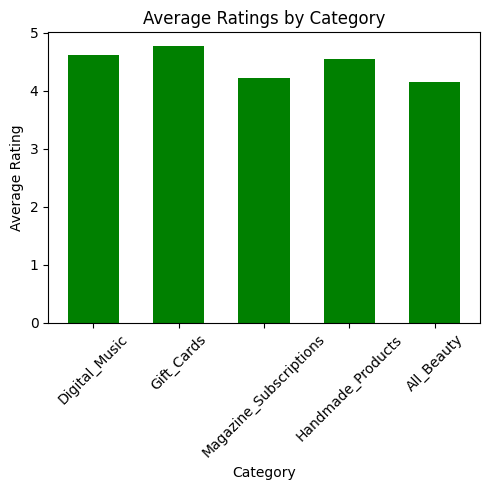

In [29]:
# Get the average rating for each category
average_ratings = {}
for category in categories:
    average_rating = dataframes['review'][category]['rating'].mean()
    average_ratings[category] = average_rating

# Plot the average ratings
plt.figure(figsize=(5, 5))
plt.bar(average_ratings.keys(), average_ratings.values(), color='green', width=0.6)
plt.xlabel("Category")
plt.ylabel("Average Rating")
plt.title("Average Ratings by Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In the above graph we can see that the `Gift_Cards` category has larger average rating than the other 4 categories. The `Digital_music` seems to have almost the same rating as `Gift_Cards`, but `All_Beauty` is having the lowest average rating of all the categories.

#### 2.2 Many Reviews but Low Ratings
Next we will identify the products with **high number of reviews**, but **low ratings**. Specifically we define the following rules:
- **High Reviews Products** are those with `number_of_reviews` being higher than the 75% of the maximum reviews
- **Low Rating** is considered to be lower than `2.5`

First we will create a function that will calculate and return the products with high number of reviews but low ratings for every category.

In [30]:
def get_high_reviews_low_ratings_products(dataframes, categories, high_review_threshold=0.75, low_rating_threshold=2.5):
    """
    Identifies products with high reviews and low ratings.
    """
    high_reviews_low_ratings_products = []

    # Iterate through each category to find products with high reviews and low ratings
    for category in categories:
        products_reviews = {product_id: [] for product_id in dataframes['review'][category]['asin']}

        # Populate the products_reviews dictionary with reviews, ratings, and product IDs
        for _, row in dataframes['review'][category].iterrows():
            rating, review, product_id = row['rating'], str(row['cleaned_text']), row['asin']
            products_reviews[product_id].append((rating, review))

        # Filter products with high reviews and low ratings, and store them in the list
        for product_id, value in products_reviews.items():
            if len(value) >= high_review_threshold:  # Only consider products with high reviews
                average_rating = sum(rating for rating, _ in value) / len(value)
                if average_rating <= low_rating_threshold:
                    high_reviews_low_ratings_products.append({
                        'category': category,
                        'product_id': product_id,
                        'average_rating': average_rating,
                        'reviews': value
                    })

    return high_reviews_low_ratings_products

Next we will construct a function that will return the most common keywords from the products.

In [31]:
def get_common_keywords(high_reviews_low_ratings_products):
    """
    Extracts and counts common keywords from reviews of products with high reviews and low ratings.
    """
    common_keywords = {}

    # Iterate through the products with high reviews and low ratings, and count keywords
    for product in high_reviews_low_ratings_products:
        reviews = product['reviews']
        for _, review in reviews:
            words = review.split()
            for word in words:
                if word not in common_keywords:
                    common_keywords[word] = 0
                common_keywords[word] += 1

    # Sort the keywords by frequency and return the top common keywords
    common_keywords = dict(sorted(common_keywords.items(), key=lambda item: item[1], reverse=True))
    
    return common_keywords

Let's test these functions and get the product of this type. We remind you that products with high number of reviews are meant to be those with 100 and more reviews and ratings that are smaller than 2.5 are considered to be low ratings.

In [32]:
HIGH_REVIEW_THRESHOLD = 100  # Threshold for high reviews (100 or more)
LOW_RATING_THRESHOLD = 2.5  # Threshold for low ratings (2.5 or below)

# Get the products with high reviews and low ratings
high_reviews_low_ratings_products = get_high_reviews_low_ratings_products(dataframes, categories, HIGH_REVIEW_THRESHOLD, LOW_RATING_THRESHOLD)
common_keywords = get_common_keywords(high_reviews_low_ratings_products)

Let's have a look at the products received and plot the most common keywords of these products.

In [33]:
print(f"Number of products with high reviews and low ratings: {len(high_reviews_low_ratings_products)}")
high_reviews_low_ratings_df = pd.DataFrame({
    'category': [product['category'] for product in high_reviews_low_ratings_products],
    'product_id': [product['product_id'] for product in high_reviews_low_ratings_products],
    'average_rating': [product['average_rating'] for product in high_reviews_low_ratings_products],
    'reviews_count': [len(product['reviews']) for product in high_reviews_low_ratings_products]
})
high_reviews_low_ratings_df.head()

Number of products with high reviews and low ratings: 0


,category,product_id,average_rating,reviews_count


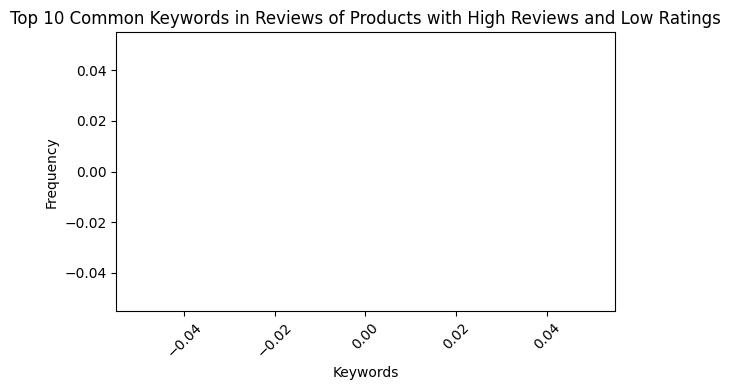

In [34]:
# Plot the top 10 common keywords
plt.figure(figsize=(6, 4))
plt.bar(list(common_keywords.keys())[:10], list(common_keywords.values())[:10], color='orange', width=0.7)
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.title("Top 10 Common Keywords in Reviews of Products with High Reviews and Low Ratings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 2.3 Top 5 Best Selling products
Next we will identify the top 5 best selling products of each category. As **best selling** we define those products with the highest number of reviews. We will also represent the features of these products.

In [35]:
top_best_selling_products = {} # Define a dictionary to keep the best selling products for every category

for category in categories:
    sorted_meta = dataframes['meta'][category].sort_values(by='rating_number', ascending=False)
    top_best_selling_products[category] = sorted_meta.head(5)

# Display the top 5 best-selling products for All_Beauty category
top_best_selling_products[categories[0]]

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,normalized_price,cleaned_title
333,Digital Music,Memory Man by David Baldacci (2015-04-21),4.4,97719,[],[],35.82,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",David Baldacci Format: Audio CD,[],"{""Manufacturer"": ""Grand Central Publishing"", ""...",B0146V24OI,[],NaN,NaN,0.039316,memori man david baldacci 20150421
283,Digital Music,Sam Smith: In The Lonely Hour [CD] by Sam Smit...,4.7,9561,[],[],0.00,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Sam Smith Format: Audio CD,[],"{""Package Dimensions"": ""5.55 x 4.88 x 0.35 inc...",B00PO5EALQ,[],NaN,NaN,0.000000,sam smith lone hour cd sam smith music cd
167,Digital Music,Lightning [Audio CD],4.5,7723,[],[],0.00,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Format: Unknown Binding,[],"{""Date First Available"": ""August 20, 2012""}",B00846AI22,[],NaN,NaN,0.000000,lightn audio cd
332,Digital Music,Monster-in-Law (New Line Platinum Series) by J...,4.7,5733,[],[],4.37,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Format: Audio CD,[],"{""Package Dimensions"": ""7.44 x 5.39 x 0.51 inc...",B01M8PMRX1,[],NaN,NaN,0.004797,monsterinlaw new line platinum seri jennif lopez
394,Digital Music,Greatest Hits,4.7,5397,[],['It may surprise some to realize that Guns N\...,16.63,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Guns N' Roses Format: Audio CD,[],"{""Package Dimensions"": ""5.51 x 4.92 x 0.28 inc...",B08QXX9CVC,[],NaN,NaN,0.018253,greatest hit


Let's show these products with their feature list.

In [36]:
# Print the features of the top best-selling products
for category, products in top_best_selling_products.items():
    print(f"\nTop 5 Best-Selling Products in {category}:")
    for _, product in products.iterrows():
        print(f" - Product ID: {product['parent_asin']} (Number of Ratings: {product['rating_number']})")
        features = product['features'].split("', '")
        if features[0] == "[]":
            print("   > No features available")
        else:
            for feature in features:
                cleaned_feature = feature.replace("['", "").replace("']", "")
                print(f"   > Feature: {cleaned_feature}")
        print('\n')


Top 5 Best-Selling Products in Digital_Music:
 - Product ID: B0146V24OI (Number of Ratings: 97719)
   > No features available


 - Product ID: B00PO5EALQ (Number of Ratings: 9561)
   > No features available


 - Product ID: B00846AI22 (Number of Ratings: 7723)
   > No features available


 - Product ID: B01M8PMRX1 (Number of Ratings: 5733)
   > No features available


 - Product ID: B08QXX9CVC (Number of Ratings: 5397)
   > No features available



Top 5 Best-Selling Products in Gift_Cards:
 - Product ID: B00ADR2LV6 (Number of Ratings: 185606)
   > Feature: Gift Card is affixed inside a box
   > Feature: Gift amount may not be printed on Gift Cards
   > Feature: You can customize the gift amount as desired, for example $36, $54, $72, etc.
   > Feature: Gift Card has no fees and no expiration date
   > Feature: Gift Card is redeemable towards millions of items storewide at Amazon.com
   > Feature: Scan and redeem any Gift Card with a mobile or tablet device via the Amazon App
   > Feat

#### 2.4 Products Average Ratings per year
The last task is to analyze and visualize how average product rating has evolved within each category over the years. We will start by translating the **`timestamp`** column every category has, witch is represented as a **unix timestamp** in milliseconds, and receiving a more human read representation of it (dd-mm-yyyy).

In [37]:
import datetime

for category in categories:
    dataframes['review'][category]['timestamp_formatted'] = dataframes['review'][category]['timestamp'].apply(
        lambda x: datetime.datetime.fromtimestamp(x/1000)
    )

dataframes['review']['Gift_Cards'].tail()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,cleaned_title,cleaned_text,timestamp_formatted
995,5.0,She could buy whatever she wanted!,It was a perfect Christmas gift!,[],B01K8RJDEI,B00ADR2LV6,AHTFJNXOEO64MQHVOH3AGYF4HE7Q,1613427766696,0,True,could buy whatev want,perfect christma gift,2021-02-16 00:22:46.696
996,5.0,Great for frequent shoppers. Another super eas...,"What’s not to like? It’s quick, it’s easy, and...",[],B00IX1I3G6,B00IX1I3G6,AEYX2YVU5NMPPS5ZQASTWKDWPUJQ,1537034354280,1,True,great frequent shopper anoth super easi paymen...,what like quick easi want buy someth cash bala...,2018-09-15 20:59:14.280
997,5.0,AMAZING!,I stumbled on this while looking for a graduat...,[],B01N9GY4GF,B01B3DYSF0,AGWZ5RENSFTTMRPUJODLLF5QLIJQ,1591647031252,0,False,amaz,stumbl look graduat card glad graduat cap box ...,2020-06-08 23:10:31.252
998,5.0,Cute package and easy to send,Wonderful gift idea,[],B0719C5P56,B0719C5P56,AGGAPGKPBGYIAIR3WK2ZIZYJ2OHA,1550340026239,0,True,cute packag easi send,wonder gift idea,2019-02-16 20:00:26.239
999,5.0,Nice way to plan and save,I like this feature because I can add to it mo...,[],B086KKT3RX,B086KKT3RX,AEWOYZ3H3FV72KC5HJ7MH7QCQ55A,1659046792988,0,True,nice way plan save,like featur add monthli wheneverbr valu build ...,2022-07-29 01:19:52.988


As we can see from the above dataframe, we have successfully created a new column with the formatted timestamp and we can easily work with it by extracting the year, the month, etc. We will now create a function that will return to us the average rating for every year.

In [38]:
# Get the average rating per year for each category
def get_average_rating_per_year(dataframes, categories):
    average_ratings_per_year = {}

    for category in categories:
        df = dataframes['review'][category]
        df['year'] = df['timestamp_formatted'].dt.year
        average_ratings = df.groupby('year')['rating'].mean().reset_index()
        average_ratings_per_year[category] = average_ratings

    return average_ratings_per_year

In [39]:
average_ratings_per_year = get_average_rating_per_year(dataframes, categories)

By executing the code above we have successfully extracted the average rating per year for the products of every category. Let's visualize this trend in a line plot.

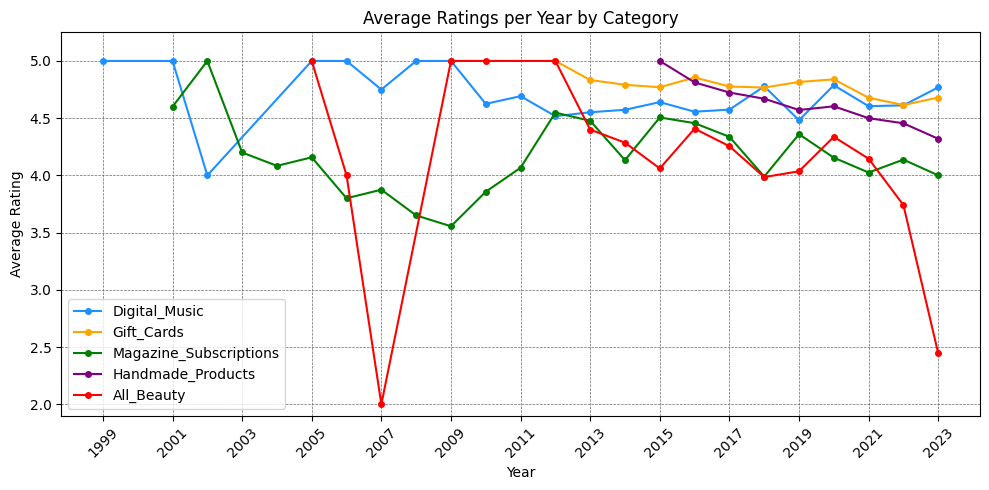

In [40]:
# Plot the average ratings per year for each category
colors = ['dodgerblue', 'orange', 'green', 'purple', 'red']
plt.figure(figsize=(10, 5))
for i, (category, average_ratings) in enumerate(average_ratings_per_year.items()):
    plt.plot(average_ratings['year'], average_ratings['rating'], color=colors[i], marker='o', markersize=4, label=category)

min_year = min(min(average_ratings['year']) for average_ratings in average_ratings_per_year.values())
max_year = max(max(average_ratings['year']) for average_ratings in average_ratings_per_year.values())

min_y = min(min(average_ratings['rating']) for average_ratings in average_ratings_per_year.values())
max_y = max(max(average_ratings['rating']) for average_ratings in average_ratings_per_year.values())

plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.title("Average Ratings per Year by Category")
plt.xticks(rotation=45)
plt.xticks(range(min_year, max_year+1, 2))
plt.ylim(min_y - 0.05*min_y, max_y + 0.05*max_y)
plt.grid(color='dimgray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

As we can see from the above graph the earliest year production has started is 1997 and it is refered to the **Digital_Music** category. We will also define a function that will return to us the monthly average rating for a specific year.

In [41]:
def get_average_rating_for_year(dataframes, categories, year):
    """
    Returns the average rating for every month for a specific year across all categories.
    """
    average_ratings = {}

    for category in categories:
        df = dataframes['review'][category]
        df['year'] = df['timestamp_formatted'].dt.year
        df['month'] = df['timestamp_formatted'].dt.month

        # Filter the dataframe for the specified year
        df_year = df[df['year'] == year]

        # Calculate the average rating per month
        monthly_average = df_year.groupby('month')['rating'].mean().reset_index()
        average_ratings[category] = monthly_average

    return average_ratings

Below we test the function that we have just created for the year **2021** and we represent the results also in a line plot.

In [42]:
year = 2021
average_ratings_2021 = get_average_rating_for_year(dataframes, categories, year)

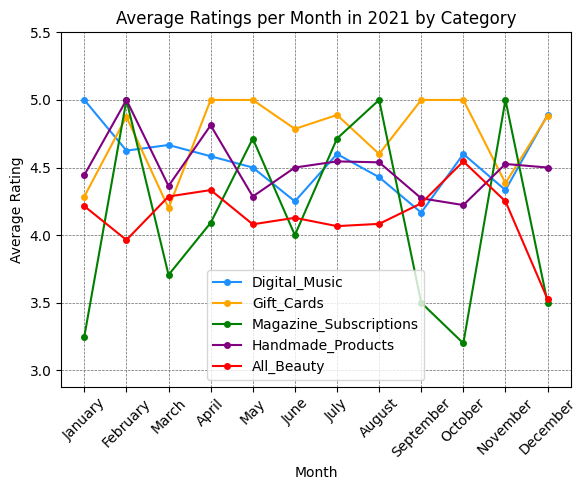

In [43]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot the average ratings per month for the specified year
colors = ['dodgerblue', 'orange', 'green', 'purple', 'red']
plt.figure(figsize=(6, 5))
for i, (category, average_ratings) in enumerate(average_ratings_2021.items()):
    plt.plot(average_ratings['month'], average_ratings['rating'], color=colors[i], marker='o', markersize=4, label=category)

min_month = min(min(avg['month']) for avg in average_ratings_2021.values() if not avg['month'].empty)
max_month = max(max(avg['month']) for avg in average_ratings_2021.values() if not avg['month'].empty)

min_y = min(min(avg['rating']) for avg in average_ratings_2021.values() if not avg['rating'].empty)
max_y = max(max(avg['rating']) for avg in average_ratings_2021.values() if not avg['rating'].empty)

plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.title(f"Average Ratings per Month in {year} by Category")
plt.xticks(rotation=45)
plt.xticks(range(1, 13), months)
plt.ylim(min_y -0.1*min_y, max_y + 0.1*max_y)  # Adjust y-axis limits based on the dataset
plt.grid(color='dimgray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

## Task 2: Feature Engineering with Sentiment Scores and Ratings
In the second task we had to choose between **two alternative methods** to combine text sentiment and review ratings to create a final sentiment score. Specifically the methods we were offered with are the following:
1. Alternative 1: **Weighted Combination of Text Sentiment and Rating**, and
2. Alternative 2: **Rating-Adjusted Sentiment**

In this work we chose to work with the first alternative, thinking that it will suit better to extract the final sentiment score.

### VADER Download
From the available options of extracting a base sentiment according to the review text, we prefer to work with **VADER**, a simple light weight sentiment classifier. This classifier takes as input a specific text, and outputs a score refering to its sentiment, specifically from **-1 (negative)** to **+1 (positive)**. Let's download the classifier.

In [44]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER classifier
nltk.download('vader_lexicon')
classifier = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/antonis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Extracting Default Sentiment
After downloading the classifier for sentiment extraction from text, let's test it on our data and create a new column containing the sentiment score for each review.

In [45]:
if os.path.exists('../data/sentimented'):
    print('Sentiments have already been computed. Skipping...')
else:
    for category in categories:
        print(f"Computing sentiment for {category}...")
        dataframes['review'][category]['base_sentiment'] = dataframes['review'][category]['cleaned_text'].apply(
            lambda x: classifier.polarity_scores(str(x))['compound']
        )

Sentiments have already been computed. Skipping...


### Normalizing the Rating
Before we proceed into using the rating to produce the final sentiment we need to normalize the rating column to the range of (0, 1). This will be usefull for us if we want to cobmine it with the base sentiment that we extracted using VADER classifier. The formula that normalizes the rating is shown below:
$$
    Normalized\_Rating = \frac{Rating - 1}{4}
$$
We will apply this formula to receive the normalized rating.

In [46]:
if os.path.exists('../data/sentimented'):
    print('Ratings have already been normalized. Skipping...')
else:
    for category in categories:
        print(f"Normalizing rating for {category}...")
        dataframes['review'][category]['normalized_rating'] = dataframes['review'][category]['rating'].apply(
            lambda x: (x-1)/4
        )

Ratings have already been normalized. Skipping...


### Calculating the final Sentiment Score
Finally we will calculate the final sentiment score using the `base_sentiment` and `normalized_rating` columns that we have just computed. Specifically we will define two variables $w_1$ and $w_2$, that can be adjust to our preferences. This variables will be used in the final sentiment calculation as follows:
$$
    Final\_Sentiment\_Score = w_1 \times Base\_Sentiment + w_2 \times Normalized\_Rating
$$
Let's calculate it and store it

In [47]:
if os.path.exists('../data/sentimented'):
    for category in categories:
        dataframes['review'][category] = pd.read_csv(f'../data/sentimented/review/{category}_data.csv')
        print(f'Loaded {category} dataframe with sentiment')
else:
    os.mkdir('../data/sentimented')
    os.mkdir('../data/sentimented/review')
    
    # Define the weights of the final sentiment calculation
    w1 = 0.3
    w2 = 1.0 - w1
    
    # Calculate the final sentiment score for each category
    for category in categories:
        print(f"Computing final sentiment for {category}...")
        current_df = dataframes['review'][category]
        current_df['final_sentiment'] = w1*current_df['base_sentiment'] + w1*current_df['normalized_rating']
        current_df.to_csv(f'../data/sentimented/review/{category}_data.csv', index=False)

Loaded Digital_Music dataframe with sentiment
Loaded Gift_Cards dataframe with sentiment
Loaded Magazine_Subscriptions dataframe with sentiment
Loaded Handmade_Products dataframe with sentiment
Loaded All_Beauty dataframe with sentiment


Let's have a look at the modified `All_Beauty` dataframe and how it is so far after all the previous additions.

In [48]:
dataframes['review'][categories[0]].head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,cleaned_title,cleaned_text,timestamp_formatted,year,month,base_sentiment,normalized_rating,final_sentiment
0,5.0,Nice,If i had a dollar for how many times I have pl...,[],B004RQ2IRG,B004RQ2IRG,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,1618972613292,0,True,nice,dollar mani time play cd mani time ask alexa p...,2021-04-21 05:36:53.292,2021,4,0.9413,1.0,0.58239
1,5.0,Excellent,awesome sound - cant wait to see them in perso...,[],B0026UZEI0,B0026UZEI0,AHGAOIZVODNHYMNCBV4DECZH42UQ,1308167525000,0,True,excel,awesom sound cant wait see person alway miss town,2011-06-15 22:52:05.000,2011,6,-0.1531,1.0,0.25407
2,5.0,Great service,This is a great cd. Good music and plays well....,[],B0055JSYHC,B0055JSYHC,AFGEM6BXCYHUILEOA3P2ZYBEF2TA,1615838793006,0,True,great servic,great cd good music play well seller respond b...,2021-03-15 22:06:33.006,2021,3,0.8885,1.0,0.56655
3,1.0,No good,"These are not real German singers, they have a...",[],B000F9SMUQ,B000F9SMUQ,AH3OG6QD6EDJGZRVCFKV4B66VWNQ,1405219741000,0,True,good,real german singer accent noth advertis music ...,2014-07-13 05:49:01.000,2014,7,-0.4019,0.0,-0.12057
4,3.0,"Cool concept, so-so execution...",I first heard this playing in a Nagoya shop an...,[],B0049D1WVK,B0049D1WVK,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,1309029595000,0,False,cool concept soso execut,first heard play nagoya shop fell love remix k...,2011-06-25 22:19:55.000,2011,6,0.9690,0.5,0.44070


As we can see the final sentiment score has been successfully computed and stored inside the `final_sentiment` column.

# Part 2: Learning Tasks
In the second part we will apply machine learning techniques for clustering, recommendation systems, and sentiment analysis.

## Task 1: Clustering for Product Grouping
In the first task we will group similar products within categories based on features like price, description, and ratings.

### 1.1 Preprocessing
Our first sub-task is to **preprocess** the text data for model training by standardizing the input and **scale numerical features** (price, ratings) to prevent them from dominating the clustering. The **preprocessing** part has already been done in **Part 1**. So the only thing left is to normalize the features `price` and `average_rating` in the **meta data**.

In [49]:
# Normalize the average rating and price in the meta dataframes
for category in categories:
    print(f'Normalizing average rating and price for {category}...')
    dataframes['meta'][category]['normalized_average_rating'] = dataframes['meta'][category]['average_rating'].apply(
        lambda x: (x-1)/4
    )
    max_price = dataframes['meta'][category]['price'].max()
    dataframes['meta'][category]['normalized_price'] = dataframes['meta'][category]['price'].apply(
        lambda x: x/max_price if max_price > 0 else 0.0
    )

Normalizing average rating and price for Digital_Music...
Normalizing average rating and price for Gift_Cards...
Normalizing average rating and price for Magazine_Subscriptions...
Normalizing average rating and price for Handmade_Products...
Normalizing average rating and price for All_Beauty...


In [50]:
dataframes['meta'][categories[0]].head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,normalized_price,cleaned_title,normalized_average_rating
0,Digital Music,Baja Marimba Band,4.9,8,[],[],0.00,"{'hi_res': [None, None], 'large': ['https://m....","{'title': [], 'url': [], 'user_id': []}",NaN,[],"{""Date First Available"": ""February 28, 2010""}",B000V87RP2,[],NaN,NaN,0.000000,baja marimba band,0.975
1,Digital Music,'80s Halloween-All Original Artists & Recordings,5.0,3,[],[],14.98,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}","Love and Rockets (Artist), Duran Duran (...",[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc...",B0062F0MJQ,[],NaN,NaN,0.016442,80 halloweenal origin artist record,1.000
2,Digital Music,TRIO +1,5.0,1,[],['CD ALBUM'],57.99,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Rob Wasserman Format: Audio CD,[],"{""Is Discontinued By Manufacturer"": ""No"", ""Pac...",B00005GT12,[],NaN,NaN,0.063650,trio 1,1.000
3,Digital Music,"Gold and Silver: Lehar, Delibes, Lanner, Johan...",5.0,1,[],[],29.91,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}","Franz Lehar (Composer), Leo Delibes (Com...",[],"{""Manufacturer"": ""Hungaroton / White Label"", ""...",B0007PD2BW,[],NaN,NaN,0.032829,gold silver lehar delib lanner johann strauss ii,1.000
4,Digital Music,Grateful Dead Dave's Picks Volume 25 Live at B...,4.9,20,[],['Sold out. Numbered limited edition'],149.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}","Grateful Dead (Artist, Orchestra) Format: ...",[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc...",B079CPD45R,[],NaN,NaN,0.164629,grate dead dave pick volum 25 live broom count...,0.975


### 1.2 Vectorization
Next we will **vectorize** our data using the **TF-IDF** vectorizer. Specifically we will:
- vectorize the products descriptions and experiment with different values of `max_features` parameter to limit vocabulary size, and
- combine numerical features like ratings and prices with the TF-IDF vectors into a single feature matrix

We will start by vectorizing our data using their `description` feature and **TF-IDF** vectorizer. The result for each category should be a matrix $A$ having the following form:
$$
    A = \begin{bmatrix}
            a_{11} & a_{12} & \dots & a_{1n} \\
            a_{21} & a_{22} & \dots & a_{2n} \\
            \vdots & \vdots & \ddots & \vdots \\
            a_{m1} & a_{m2} & \dots & a_{mn} \\
        \end{bmatrix}
        \in
        \mathbb{R}^{m \times n}
$$

where $m$ is the number of records and $n$ also known as `max_features` is the maximum number of words to keep in every description. We will start by initializing this value with **100** and perform some experiments later on.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_descriptions(dataframes, categories, max_features=None):
    """ Computes the TF-IDF vectors for the product descriptions in the meta dataframes. """
    tfidf_matrices = {}

    # Loop through each category and compute the TF-IDF vectors
    for category in categories:
        print(f"Computing TF-IDF vectors for {category}...")

        # Define the vectorizer and get the descriptions as a list
        vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
        descriptions = dataframes['meta'][category]['description'].fillna('').tolist()

        # Fit the vectorizer and transform the descriptions into TF-IDF vectors
        tfidf_matrix = vectorizer.fit_transform(descriptions)
        tfidf_matrices[category] = {
            'vectorizer': vectorizer,
            'tfidf_matrix': tfidf_matrix.toarray()
        }

    return tfidf_matrices

In [52]:
tfidf_matrices = get_tfidf_descriptions(dataframes, categories, max_features=1000)

Computing TF-IDF vectors for Digital_Music...
Computing TF-IDF vectors for Gift_Cards...
Computing TF-IDF vectors for Magazine_Subscriptions...
Computing TF-IDF vectors for Handmade_Products...
Computing TF-IDF vectors for All_Beauty...


Let's visualize this resulting matrix to understand better what we are working with. We will create a **Pandas Dataframe** containing the values of this matrix

In [53]:
# Display a sample of the TF-IDF matrix for the 'All_Beauty' category as a Pandas DataFrame
import pandas as pd

tfidf_df_sample = pd.DataFrame(
    tfidf_matrices[categories[0]]['tfidf_matrix'],
    columns=tfidf_matrices[categories[0]]['vectorizer'].get_feature_names_out()
)
tfidf_df_sample.head()

,00,01,02,03,04,05,06,07,08,09,...,ye,year,years,yeh,yes,yo,yoga,york,young,zappa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will also combine some numerical values (`normalized_average_rating`, `normalized_prices`) and TF-IDF vectors into a single feature matrix.

In [54]:
import numpy as np

def combine_features(dataframes, tfidf_matrices, categories):
    """ Combines numerical features and TF-IDF vectors into a single feature matrix for each category. """
    combined_features = {}

    for category in categories:
        print(f"Combining features for {category}...")

        # Get the numerical features from the meta dataframe
        numerical_features = dataframes['meta'][category][['normalized_average_rating', 'normalized_price']].values

        # Get the TF-IDF vectors
        tfidf_vectors = tfidf_matrices[category]['tfidf_matrix']

        # Combine the numerical features and TF-IDF vectors
        combined_matrix = np.hstack((numerical_features, tfidf_vectors))
        combined_features[category] = combined_matrix

    return combined_features

In [55]:
combined_features = combine_features(dataframes, tfidf_matrices, categories)

Combining features for Digital_Music...
Combining features for Gift_Cards...
Combining features for Magazine_Subscriptions...
Combining features for Handmade_Products...
Combining features for All_Beauty...


### 1.3 Clustering
It's time to perform the clustering to our data. We will use the **K-Means** algorithm. We will also try to visualize the clusters.

In [56]:
from sklearn.cluster import KMeans

def cluster_products(combined_features, categories, n_clusters=5, printing=True):
    """ Clusters the products in each category using KMeans clustering. """
    clustered_products = {}

    for category in categories:
        if printing:
            print(f"Clustering products for {category}...")
        
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(combined_features[category])
        
        # Store the labels in the dataframe
        dataframes['meta'][category]['cluster'] = labels
        clustered_products[category] = labels

    return clustered_products

Let's make 5 clusters

In [57]:
clusters_count = 5
clustered_products = cluster_products(combined_features, categories, n_clusters=clusters_count)

Clustering products for Digital_Music...
Clustering products for Gift_Cards...
Clustering products for Magazine_Subscriptions...
Clustering products for Handmade_Products...
Clustering products for All_Beauty...


After clustering our data, we can try to visualize the clusters. In order to visualize our data we need to reduce its dimensions. We will use **PCA** (Principal Component Analysis) to reduce our data dimensions to 2.
$$
    \begin{bmatrix}
        a_{1} \\
        a_{2} \\
        \vdots \\
        a_{m} \\
    \end{bmatrix}
    \xrightarrow[]{PCA}
    \begin{bmatrix}
        b_{1} \\
        b_{2} \\
    \end{bmatrix}
$$

In [58]:
from sklearn.decomposition import PCA

def get_reduced_features(combined_features, n_components=2):
    """ Reduces the dimensionality of the combined features using PCA. """
    reduced_features = {}

    # Loop through each category and apply PCA to reduce the dimensionality
    for category in categories:
        print(f"Reducing features for {category}...")
        
        # Apply PCA to the combined features, reducing to n_components
        pca = PCA(n_components=n_components)
        reduced_matrix = pca.fit_transform(combined_features[category])
        reduced_features[category] = reduced_matrix

    return reduced_features

In [59]:
reduced_features = get_reduced_features(combined_features, n_components=2)

Reducing features for Digital_Music...
Reducing features for Gift_Cards...
Reducing features for Magazine_Subscriptions...
Reducing features for Handmade_Products...
Reducing features for All_Beauty...


Let's plot our data

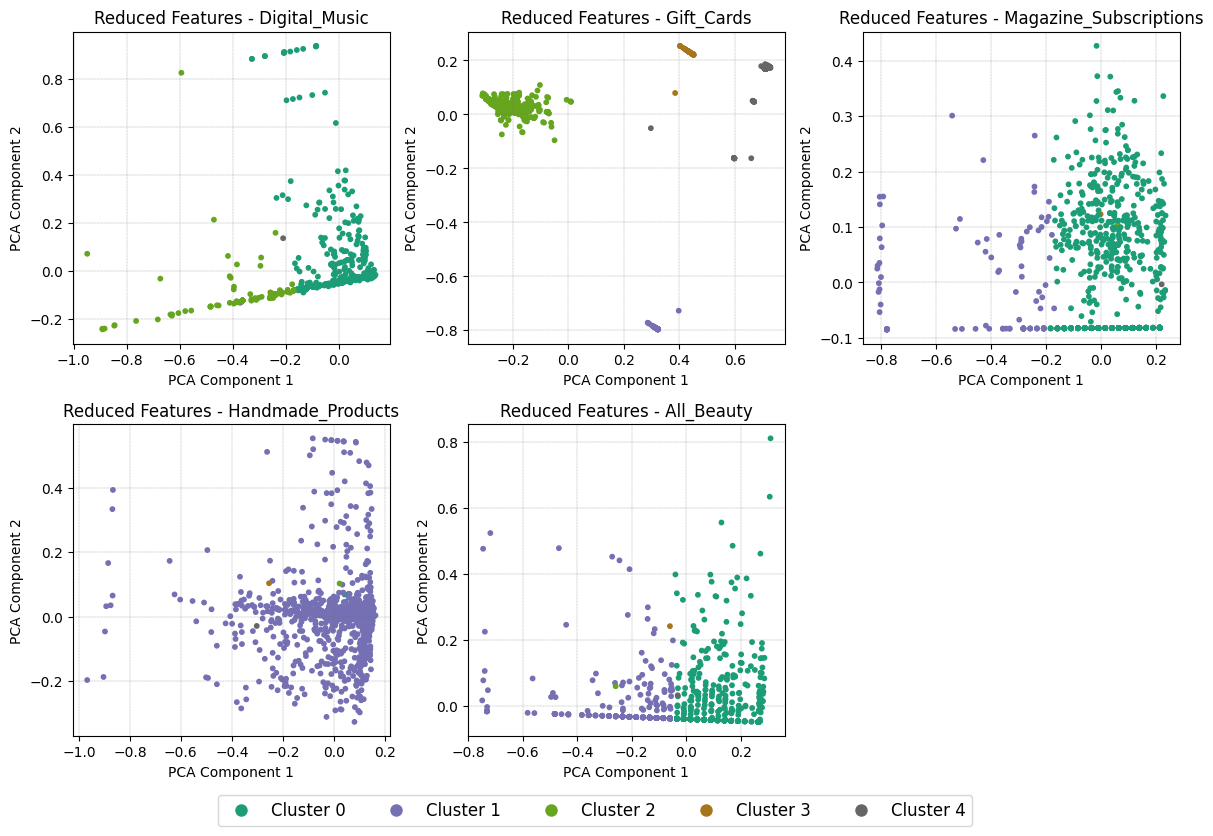

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Plot the reduced features for each category
for i, category in enumerate(categories):
    scatter = axes[i].scatter(
        reduced_features[category][:, 0], 
        reduced_features[category][:, 1],
        c=clustered_products[category], 
        cmap='Dark2',
        s=10
    )
    axes[i].set_title(f"Reduced Features - {category}")
    axes[i].set_xlabel("PCA Component 1")
    axes[i].set_ylabel("PCA Component 2")
    axes[i].grid(color='dimgray', linestyle='dashed', linewidth=0.2)

# Hide any unused subplot axes
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

# Add a general legend at the bottom
unique_labels = set(clustered_products[categories[0]])  # Assuming all categories have the same clusters
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}')
    for label in unique_labels
]
fig.legend(handles=legend_handles, loc='lower center', fontsize='large', ncol=5, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

In [61]:
from sklearn.metrics import silhouette_score

def calculate_silhouette_score(combined_features, clustered_products, categories):
    ''' Calculates the silhouette score for each category. '''
    silhouette_scores = {}
    for category in categories:
        print(f"Calculating Silhouette Score for {category}...")
        X = combined_features[category]
        labels = clustered_products[category]
        score = silhouette_score(X, labels)
        silhouette_scores[category] = score
    return silhouette_scores

silhouette_scores = calculate_silhouette_score(combined_features, clustered_products, categories)

Calculating Silhouette Score for Digital_Music...
Calculating Silhouette Score for Gift_Cards...
Calculating Silhouette Score for Magazine_Subscriptions...
Calculating Silhouette Score for Handmade_Products...
Calculating Silhouette Score for All_Beauty...


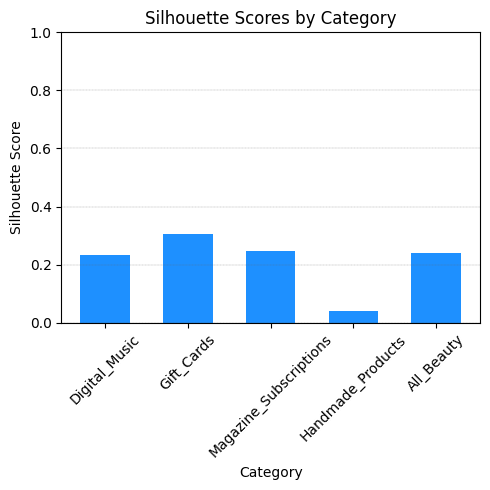

In [62]:
plt.figure(figsize=(5, 5))
plt.bar(categories, silhouette_scores.values(), color='dodgerblue', width=0.6)  # Adjusted bar width
plt.xlabel("Category")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores by Category")
plt.xticks(rotation=45) 
plt.ylim(0, 1)
plt.grid(axis='y', color='dimgray', linestyle='dashed', linewidth=0.2)
plt.tight_layout()
plt.show()

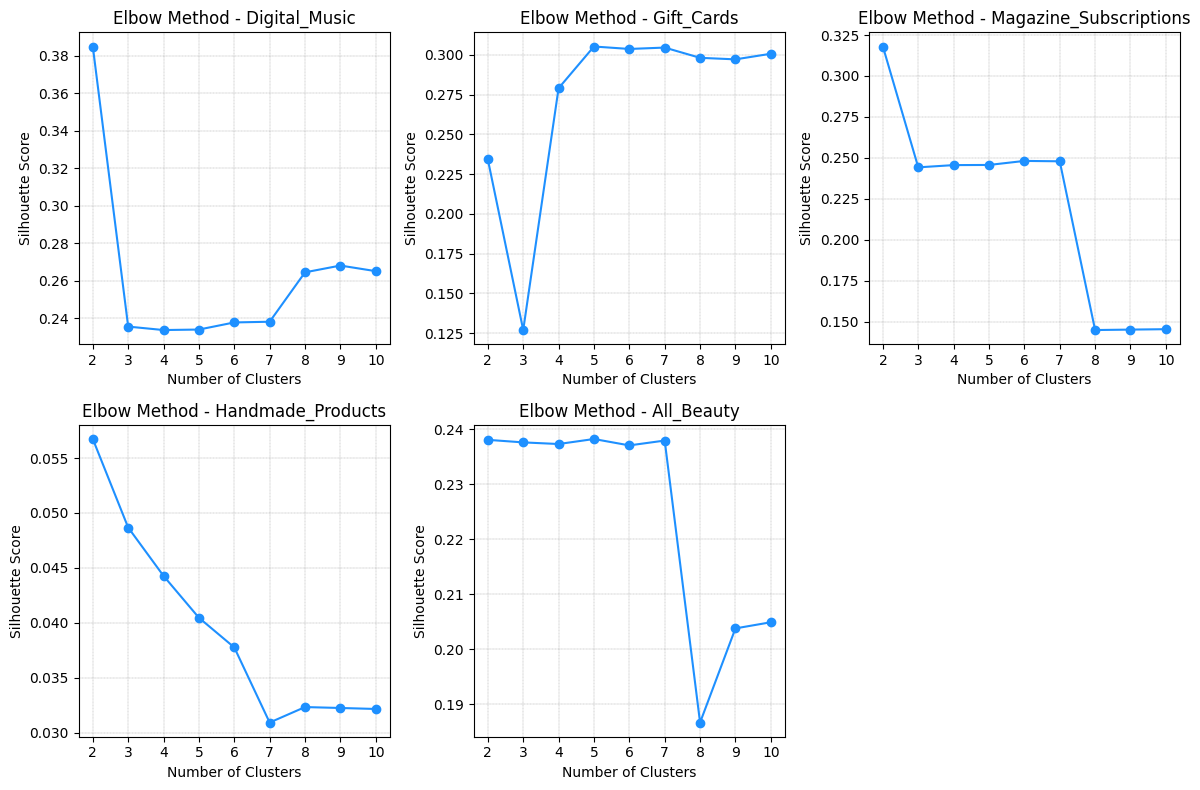

In [63]:
def plot_elbow_method_grid(combined_features, categories, max_clusters=10):
    ''' Plots the elbow method for each category in a grid layout. '''
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        X = combined_features[category]
        silhouette_scores = []
        for k in range(2, max_clusters + 1):
            clustered_products = cluster_products(combined_features, categories, n_clusters=k, printing=False)
            score = silhouette_score(X, clustered_products[category])
            silhouette_scores.append(score)

        # Plot silhouette scores vs. number of clusters
        axes[i].plot(range(2, max_clusters + 1), silhouette_scores, color='dodgerblue', marker='o')
        axes[i].set_title(f"Elbow Method - {category}")
        axes[i].set_xlabel("Number of Clusters")
        axes[i].set_ylabel("Silhouette Score")
        axes[i].set_xticks(range(2, max_clusters + 1))
        axes[i].grid(color='dimgray', linestyle='dashed', linewidth=0.2)

    # Hide any unused subplot axes
    for j in range(len(categories), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_elbow_method_grid(combined_features, categories)

## Task 2: Recommendation System
The second task of the **Learning Tasks** part, is to build a recommendation system that suggests products to users based on past behavior and preferences. This task involves two major techniques: **Collaborative Filtering** and **Content-Based Filtering**. We are going to use one category for the implementation.

### 2.1 Collaborative Filtering (CF)
For Collaborative Filtering the data needs to be in a suitable format (user-item interactions, ratings). We will need the following fields from the dataset: 
- `user_id`,
- `asin`, and
- `rating`

The system implemention contains a **user-based** and **item-based** collaborative filtering (CF) system that generates personalized book recommendations for a given user. Based on the user’s past purchases and ratings, the CF system should recommend the products with their predicted scores. We will evaluate the recommendations by showing the top-K recommended products and their predicted ratings.

#### 2.1.1 User-Based Collaborative Filtering
We will start by creating a **user-item matrix** from the training data, filling missing values with 0. We will then calculate the cosine similarity between users using `sklearn.metrics.pairwise.cosine_similarity`. Finally for each user-item pair in the test set we will:
- find the K most similar users from the training set.
- calculate a predicted rating based on the weighted average of ratings from the similar users.

In [64]:
category = categories[2]  # Choose a category for training and testing

# Select the working dataframe and get only 'user_id', 'asin', and 'rating' columns 
working_df = dataframes['review'][category].copy()
working_df = working_df[['user_id', 'asin', 'rating']]

working_df.head()


,user_id,asin,rating
0,AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ,B00HLSSQKK,5.0
1,AHORTSSMI6ZZFUFWMPT4UFR2ISUQ,B002PXW04Y,4.0
2,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,B00HCR5090,5.0
3,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,B0000ARXXS,5.0
4,AFUB7CHTXRPD447QVQCHBZVN2IPQ,B0025ZOVEO,1.0


In [65]:
# Take the 20% of the data for testing
test_df = working_df.iloc[-int(len(working_df) * 0.2):]
train_df = working_df

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 1000
Testing set size: 200


In [66]:
# Create a user-item matrix for the training set
user_item_matrix = train_df.copy()
user_item_matrix.drop_duplicates(subset=['user_id', 'asin'], inplace=True)
user_item_matrix_numpy = np.array(
    user_item_matrix.pivot(index='user_id', columns='asin', values='rating').fillna(0)
)

print(user_item_matrix_numpy.shape)

(625, 495)


In [67]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(user_item_matrix_numpy)
print(f"Similarity matrix shape: {similarity_matrix.shape}")

Similarity matrix shape: (625, 625)


In [68]:
# Step 1: Extract unique user_ids and create a mapping
unique_user_ids = train_df['user_id'].unique()
unique_asins = train_df['asin'].unique()
user_id_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids)}
asin_to_index = {asin: index for index, asin in enumerate(unique_asins)}

In [69]:
# Step 2: Access similar users for a specific user_id
def get_similar_users(user_id, similarity_matrix, user_id_to_index, top_n=5):
    if user_id not in user_id_to_index:
        print(f"User ID {user_id} not found in the training data.")
        return []
    
    # Get the index of the user_id
    user_index = user_id_to_index[user_id]
    
    # Retrieve the similarity scores for the user
    similar_users_scores = similarity_matrix[user_index]
    
    # Sort the users by similarity score (excluding the user itself)
    similar_users = sorted(
        enumerate(similar_users_scores),
        key=lambda x: x[1],
        reverse=True
    )
    
    # Map indices back to user_ids and exclude the user itself
    similar_users = [
        (unique_user_ids[i], score)
        for i, score in similar_users
        if unique_user_ids[i] != user_id
    ]
    
    # Return the top N similar users
    return similar_users[:top_n]

In [70]:
for user_id, asin in test_df[['user_id', 'asin']].values:
    similar_users = get_similar_users(user_id, similarity_matrix, user_id_to_index, top_n=200)
    sum_ratings = 0
    total_similarity = 0

    for similar_user_id, score in similar_users:
        user_index = user_id_to_index[similar_user_id]
        product_index = asin_to_index[asin]
        similar_user_rating = user_item_matrix_numpy[user_index, product_index]

        if similar_user_rating > 0:  # Only consider users who have rated the product
            sum_ratings += similar_user_rating * score
            total_similarity += score

    if total_similarity > 0:
        normalized_rating = sum_ratings / total_similarity
    else:
        # Fallback to global average or item average rating
        normalized_rating = user_item_matrix_numpy[:, asin_to_index[asin]].mean()

    # Add the predicted rating to the testing dataframe
    test_df.loc[
        (test_df['user_id'] == user_id) & (test_df['asin'] == asin), 
        'predicted_rating'
    ] = normalized_rating

In [71]:
test_df

,user_id,asin,rating,predicted_rating
800,AEIJLEAP4ZXCORUM42MHIVEDV5RA,B01DAP1V4U,4.0,0.0080
801,AEIJLEAP4ZXCORUM42MHIVEDV5RA,B0006PUYLY,5.0,0.0080
802,AG5DVL7SJPD25VSVXCISEBFBPOCA,B00005NIOG,2.0,0.0032
803,AHGKYQ2L53B7T2QT5RZHF3UCFGWQ,B004GVZUU4,5.0,0.0080
804,AHGKYQ2L53B7T2QT5RZHF3UCFGWQ,B001THPA58,5.0,0.0080
...,...,...,...,...
995,AFG5UEXLWKIN76UFOUAGGN2X6FWA,B001THPA26,1.0,0.0064
996,AG5AAXMWYJHCJ7IOM4VNY5NZ3MTQ,B007ZUOZ9U,4.0,0.0080
997,AHC2TIUHOXCCQNQT2IFVSRWGLXMQ,B002PXW0DK,1.0,0.0080
998,AF7POA2GTMSVMCM6OPTRDGIJ62SA,B00HG1BP0A,5.0,0.0032


#### 2.1.2 Item-Based Collaborative Filtering

In [72]:
category = categories[0]  # Choose a category for training and testing

# Select the working dataframe and get only 'user_id', 'asin', and 'rating' columns 
working_df = dataframes['review'][category].copy()
working_df = working_df[['user_id', 'asin', 'rating']]

working_df.head()


,user_id,asin,rating
0,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,B004RQ2IRG,5.0
1,AHGAOIZVODNHYMNCBV4DECZH42UQ,B0026UZEI0,5.0
2,AFGEM6BXCYHUILEOA3P2ZYBEF2TA,B0055JSYHC,5.0
3,AH3OG6QD6EDJGZRVCFKV4B66VWNQ,B000F9SMUQ,1.0
4,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,B0049D1WVK,3.0


In [73]:
# Take the 20% of the data for testing
test_df = working_df.iloc[-int(len(working_df) * 0.2):]
train_df = working_df

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 1000
Testing set size: 200


In [74]:
# Create a user-item matrix for the training set and transpose it
user_item_matrix = train_df.copy()
user_item_matrix_numpy = np.array(
    user_item_matrix.pivot(index='user_id', columns='asin', values='rating').fillna(0)
)
user_item_matrix_numpy = user_item_matrix_numpy.T  # Transpose the matrix to have items as rows

print(user_item_matrix_numpy.shape)

(952, 740)


In [75]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(user_item_matrix_numpy)
print(f"Similarity matrix shape: {similarity_matrix.shape}")

Similarity matrix shape: (952, 952)


In [76]:
def get_similar_items(item_id, similarity_matrix, asin_to_index, top_n=5):
    if item_id not in asin_to_index:
        print(f"Item ID {item_id} not found in the training data.")
        return []
    
    # Get the index of the item id
    item_index = asin_to_index[item_id]
    
    # Retrieve the similarity scores for the item
    similar_items_scores = similarity_matrix[item_index]
    
    # Sort the items by similarity score (excluding the item itself)
    similar_items = sorted(
        enumerate(similar_items_scores),
        key=lambda x: x[1],
        reverse=True
    )
    
    # Map indices back to items_ids and exclude the item itself
    similar_items = [
        (unique_asins[i], score)
        for i, score in similar_items
        if unique_asins[i] != item_id
    ]
    
    # Return the top N similar items
    return similar_items[:top_n]

In [77]:
# Step 1: Extract unique user_ids and create a mapping
unique_user_ids = train_df['user_id'].unique()
unique_asins = train_df['asin'].unique()
user_id_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids)}
asin_to_index = {asin: index for index, asin in enumerate(unique_asins)}

In [78]:
for user_id, asin in test_df[['user_id', 'asin']].values:
    similar_items = get_similar_items(asin, similarity_matrix, asin_to_index, top_n=5)
    sum_ratings = 0
    total_similarity = 0

    for similar_item_id, score in similar_items:
        item_index = asin_to_index[similar_item_id]
        user_index = user_id_to_index[user_id]
        similar_item_rating = user_item_matrix_numpy[item_index, user_index]

        if similar_item_rating > 0:  # Only consider items that have been rated by a user
            sum_ratings += similar_item_rating * score
            total_similarity += score

    if total_similarity > 0:
        normalized_rating = sum_ratings / total_similarity
    else:
        # Fallback to global average or item average rating
        normalized_rating = user_item_matrix_numpy[asin_to_index[asin], :].mean()

    # Add the predicted rating to the testing dataframe
    test_df.loc[
        (test_df['user_id'] == user_id) & (test_df['asin'] == asin), 
        'predicted_rating'
    ] = normalized_rating

In [79]:
test_df

,user_id,asin,rating,predicted_rating
800,AH6BXEDXT2FGO7EYMDPTQG7HO7VA,B014I3E6QS,5.0,0.006757
801,AH6BXEDXT2FGO7EYMDPTQG7HO7VA,B07V9SCMR4,5.0,0.006757
802,AEFQMLX72KCIFGZ634KPTI4H4UCQ,B01BH64NYO,5.0,0.006757
803,AEE73ITH4FMRJH326B2F7E5QXAVQ,B001O7YVFI,5.0,0.006757
804,AGKDNSUWEKAGQ7GMAI6JCOSUKP6Q,B00QE3EG48,5.0,0.006757
...,...,...,...,...
995,AGIW7MUCULNVHSYUFWUSKIDHAICA,B00Q515LMU,5.0,0.006757
996,AHC3V4GQF2DRXAMEEJ6S2RRIF2BQ,B001EJH4SW,5.0,0.006757
997,AEZCSRJ7EQFX2SJFITNKUPBXXK7Q,B07NV24KCZ,5.0,0.006757
998,AFFUYLZDWUQJS2QOUO7YSWUFKTEQ,B07TZ9GJKG,5.0,0.006757


## 2.2 Content-Based Filtering

In [80]:
import os
import requests
from zipfile import ZipFile

def download_glove_300d(zip_path, glove_url="https://nlp.stanford.edu/data/glove.6B.zip"):
    """Downloads and extracts only the 300d GloVe embeddings from the specified URL."""
    extract_path = os.path.dirname(zip_path)
    glove_300d_path = os.path.join(extract_path, "glove.6B.300d.txt")
    
    # Check if the 300d embeddings file already exists
    if os.path.exists(glove_300d_path):
        print(f"{glove_300d_path} already exists. Skipping download.")
        return

    if not os.path.exists(zip_path):
        print("Downloading GloVe embeddings...")
        try:
            response = requests.get(glove_url, stream=True)
            response.raise_for_status()  # Raise an error for bad status codes
        except requests.exceptions.SSLError:
            print("SSL verification failed. Retrying with SSL verification disabled...")
            response = requests.get(glove_url, stream=True, verify=False)
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print("Download completed.")
    else:
        print("GloVe embeddings zip file already exists.")

    # Extract only the 300d file
    with ZipFile(zip_path, "r") as zip_ref:
        file_to_extract = "glove.6B.300d.txt"
        if file_to_extract in zip_ref.namelist():
            zip_ref.extract(file_to_extract, extract_path)
            print(f"Extracted {file_to_extract} to {extract_path}.")
        else:
            print(f"{file_to_extract} not found in the zip file.")
    os.remove(zip_path)

# Specify the path to save the GloVe zip file
zip_path = "../data/external/glove.6B.zip"
download_glove_300d(zip_path)

../data/external/glove.6B.300d.txt already exists. Skipping download.


In [81]:
def get_description_embeddings(dataframe, glove_file="../data/external/glove.6B.300d.txt"):
    """
    Computes the GloVe embeddings for the product descriptions in the meta dataframe.
    Returns a dictionary mapping each description to its embedding.
    """
    embeddings = {}
    
    # Load GloVe embeddings
    glove_embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            glove_embeddings[word] = vector

    # Compute embeddings for each description
    for index, row in dataframe.iterrows():
        description_list = list(row['description'])
        description = ' '.join(description_list)
        words = description.split()
        embedding = np.zeros(300, dtype=np.float32)
        count = 0
        
        for word in words:
            if word in glove_embeddings:
                embedding += glove_embeddings[word]
                count += 1

        if count > 0:
            embedding /= count
        embeddings[row['parent_asin']] = embedding

    return embeddings        


In [82]:
working_df = dataframes['meta'][categories[0]].copy()
embeddings = get_description_embeddings(working_df)

In [83]:
description_matrix = np.array(list(embeddings.values()))
print(f"Description matrix shape: {description_matrix.shape}")

Description matrix shape: (1000, 300)


In [84]:
# Compute the cosine similarity matrix for the description embeddings
description_similarity_matrix = cosine_similarity(description_matrix)
print(f"Description similarity matrix shape: {description_similarity_matrix.shape}")

Description similarity matrix shape: (1000, 1000)


In [85]:
top_similar_products = {}
# Set the diagonal of the similarity matrix to -np.inf to ignore self-similarity
np.fill_diagonal(description_similarity_matrix, -np.inf)

for i, asin in enumerate(embeddings.keys()):
    similar_indices = np.argsort(description_similarity_matrix[i])[::-1][:5]  # Get top 5 similar products
    similar_asins = [list(embeddings.keys())[index] for index in similar_indices]
    top_similar_products[asin] = similar_asins

# Display the top similar products for a specific ASIN
def display_top_similar_products(asin, top_similar_products, embeddings):
    if asin not in top_similar_products:
        print(f"No similar products found for ASIN {asin}.")
        return
    
    print(f"Top similar products for ASIN {asin}:")

    for similar_asin in top_similar_products[asin]:
        print(f" - {similar_asin} (Embedding: {embeddings[similar_asin][:5]}...)")  # Display first 5 elements of the embedding

display_top_similar_products(list(embeddings.keys())[904], top_similar_products, embeddings)

Top similar products for ASIN B019H4MS7M:
 - B0006V7J5C (Embedding: [ 0.03421365 -0.0745525  -0.44300002  0.217635   -0.506055  ]...)
 - B004GLI2ZY (Embedding: [ 0.03421365 -0.0745525  -0.44300002  0.217635   -0.506055  ]...)
 - B000008PNS (Embedding: [ 0.03421365 -0.0745525  -0.44300002  0.217635   -0.506055  ]...)
 - B07LFNXQGD (Embedding: [ 0.03421365 -0.0745525  -0.44300002  0.217635   -0.506055  ]...)
 - B000056582 (Embedding: [ 0.03421365 -0.0745525  -0.44300002  0.217635   -0.506055  ]...)


In [86]:
# Display top similar products for a specific ASIN
print(working_df[working_df['parent_asin'] == 'B004GLI2ZY']['description'])
print(embeddings['B004GLI2ZY'][:5])  # Display first 5 elements of the embedding

447    []
Name: description, dtype: object
[ 0.03421365 -0.0745525  -0.44300002  0.217635   -0.506055  ]


## Task 3: Classification Task - Sentiment Analysis
Sentiment analysis aims to understand the emotional tone of **customer reviews**, classifying them as **positive**, **negative**, or **neutral**.

In [158]:
working_df = dataframes['review'][categories[1]].copy()
working_df = working_df[['cleaned_text', 'final_sentiment']]

# Turn the final sentiment into -1, 0, 1 for negative, neutral, and positive sentiments
working_df['final_sentiment'] = working_df['final_sentiment'].apply(
    lambda x: -1 if x <= 0.05 else (1 if x >= 0.05 else 0)
)

working_df.head()

,cleaned_text,final_sentiment
0,amazon money alway good,1
1,alway perfect gift never given one someon seem...,1
2,person hard shop amazon gift card p e r f e c ...,1
3,tin nice touch pretti larg 434 diamet 1234 thi...,1
4,bought pack starbuck gift card 2019 ive given ...,1


In [159]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    working_df['cleaned_text'],
    working_df['final_sentiment'],
    test_size=0.2,
    random_state=42
)

X_train = X_train.fillna('')
X_test = X_test.fillna('')

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 800
Testing set size: 200


In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

print(f"TF-IDF training set shape: {X_train_tfidf.shape}")
print(f"TF-IDF testing set shape: {X_test_tfidf.shape}")

TF-IDF training set shape: (800, 1000)
TF-IDF testing set shape: (200, 1000)


In [161]:
def get_reviews_embeddings(X, embeddings_file="../data/external/glove.6B.300d.txt"):
    glove_embeddings = {}
    with open(embeddings_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            glove_embeddings[word] = vector

    embeddings_matrix = np.zeros((len(X), 300), dtype=np.float32)

    for i, review in enumerate(X):
        words = review.split()
        embedding = np.zeros(300, dtype=np.float32)
        count = 0
        
        for word in words:
            if word in glove_embeddings:
                embedding += glove_embeddings[word]
                count += 1

        if count > 0:
            embedding /= count
        embeddings_matrix[i] = embedding

    return embeddings_matrix

In [162]:
reviews_embeddings_matrix_train = get_reviews_embeddings(X_train)
reviews_embeddings_matrix_test = get_reviews_embeddings(X_test)

print(f"Reviews embeddings training set shape: {reviews_embeddings_matrix_train.shape}")
print(f"Reviews embeddings testing set shape: {reviews_embeddings_matrix_test.shape}")

Reviews embeddings training set shape: (800, 300)
Reviews embeddings testing set shape: (200, 300)


In [163]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [164]:
# Create classifiers for the TF-IDF vectorization technique
tfidf_naive_bayes_classifier = GaussianNB()
tfidf_knn_classifier = KNeighborsClassifier(n_neighbors=5)
tfidf_random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create classifiers for the GloVe embeddings vectorization technique
embeddings_naive_bayes_classifier = GaussianNB()
embeddings_knn_classifier = KNeighborsClassifier(n_neighbors=5)
embeddings_random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [165]:
print(reviews_embeddings_matrix_train.shape, y_train.shape)

(800, 300) (800,)


In [166]:
tfidf_naive_bayes_classifier.fit(X_train_tfidf, y_train)
tfidf_knn_classifier.fit(X_train_tfidf, y_train)
tfidf_random_forest_classifier.fit(X_train_tfidf, y_train)

embeddings_naive_bayes_classifier.fit(reviews_embeddings_matrix_train, y_train)
embeddings_knn_classifier.fit(reviews_embeddings_matrix_train, y_train)
embeddings_random_forest_classifier.fit(reviews_embeddings_matrix_train, y_train)

RandomForestClassifier(random_state=42)

In [167]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [168]:
all_classifiers = {
    'tfidf_naive_bayes': (tfidf_naive_bayes_classifier, X_train_tfidf),
    'tfidf_knn': (tfidf_knn_classifier, X_train_tfidf),
    'tfidf_random_forest': (tfidf_random_forest_classifier, X_train_tfidf),
    'embeddings_naive_bayes': (embeddings_naive_bayes_classifier, reviews_embeddings_matrix_train),
    'embeddings_knn': (embeddings_knn_classifier, reviews_embeddings_matrix_train),
    'embeddings_random_forest': (embeddings_random_forest_classifier, reviews_embeddings_matrix_train)
}

In [169]:
for classifier_name, (classifier, X_train_data) in all_classifiers.items():
    scores = cross_validate(classifier, X_train_data, y_train, cv=cv, scoring=scoring)
    print(f"\n{classifier_name} 10-Fold Cross-Validation Scores:")
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"Precision: {scores['test_precision'].mean():.4f}")
    print(f"Recall: {scores['test_recall'].mean():.4f}")
    print(f"F1 Score: {scores['test_f1'].mean():.4f}")


tfidf_naive_bayes 10-Fold Cross-Validation Scores:
Accuracy: 0.9313
Precision: 0.5129
Recall: 0.5703
F1 Score: 0.5128

tfidf_knn 10-Fold Cross-Validation Scores:
Accuracy: 0.9875
Precision: 0.4938
Recall: 0.5000
F1 Score: 0.4969

tfidf_random_forest 10-Fold Cross-Validation Scores:
Accuracy: 0.9875
Precision: 0.4938
Recall: 0.5000
F1 Score: 0.4969

embeddings_naive_bayes 10-Fold Cross-Validation Scores:
Accuracy: 0.8362
Precision: 0.5125
Recall: 0.6209
F1 Score: 0.4861

embeddings_knn 10-Fold Cross-Validation Scores:
Accuracy: 0.9875
Precision: 0.4938
Recall: 0.5000
F1 Score: 0.4969

embeddings_random_forest 10-Fold Cross-Validation Scores:
Accuracy: 0.9875
Precision: 0.4938
Recall: 0.5000
F1 Score: 0.4969


In [170]:
tfidf_naive_bayes_preds = tfidf_naive_bayes_classifier.predict(X_test_tfidf)
tfidf_knn_preds = tfidf_knn_classifier.predict(X_test_tfidf)
tfidf_random_forest_preds = tfidf_random_forest_classifier.predict(X_test_tfidf)

embeddings_naive_bayes_preds = embeddings_naive_bayes_classifier.predict(reviews_embeddings_matrix_test)
embeddings_knn_preds = embeddings_knn_classifier.predict(reviews_embeddings_matrix_test)
embeddings_random_forest_preds = embeddings_random_forest_classifier.predict(reviews_embeddings_matrix_test)

In [171]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(name, y_true, y_pred):
    print(f"{name} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"{name} Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"{name} Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"{name} F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}")

print("Metrics for classifiers with TF-IDF vectorization:")
print_metrics("TF-IDF Naive Bayes", y_test, tfidf_naive_bayes_preds)
print_metrics("TF-IDF KNN", y_test, tfidf_knn_preds)
print_metrics("TF-IDF Random Forest", y_test, tfidf_random_forest_preds)

print("\nMetrics for classifiers with GloVe embeddings:")
print_metrics("GloVe Naive Bayes", y_test, embeddings_naive_bayes_preds)
print_metrics("GloVe KNN", y_test, embeddings_knn_preds)
print_metrics("GloVe Random Forest", y_test, embeddings_random_forest_preds)


Metrics for classifiers with TF-IDF vectorization:
TF-IDF Naive Bayes Accuracy: 0.9450
TF-IDF Naive Bayes Precision: 0.5477
TF-IDF Naive Bayes Recall: 0.6046
TF-IDF Naive Bayes F1 Score: 0.5627
TF-IDF KNN Accuracy: 0.9800
TF-IDF KNN Precision: 0.4900
TF-IDF KNN Recall: 0.5000
TF-IDF KNN F1 Score: 0.4949
TF-IDF Random Forest Accuracy: 0.9800
TF-IDF Random Forest Precision: 0.4900
TF-IDF Random Forest Recall: 0.5000
TF-IDF Random Forest F1 Score: 0.4949

Metrics for classifiers with GloVe embeddings:
GloVe Naive Bayes Accuracy: 0.7450
GloVe Naive Bayes Precision: 0.5249
GloVe Naive Bayes Recall: 0.7474
GloVe Naive Bayes F1 Score: 0.4783
GloVe KNN Accuracy: 0.9800
GloVe KNN Precision: 0.4900
GloVe KNN Recall: 0.5000
GloVe KNN F1 Score: 0.4949
GloVe Random Forest Accuracy: 0.9800
GloVe Random Forest Precision: 0.4900
GloVe Random Forest Recall: 0.5000
GloVe Random Forest F1 Score: 0.4949
